#Download The data 

In [ ]:
!pip install kaggle

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c cisc873-dm-f22-a6

In [ ]:
! unzip cisc873-dm-f22-a6.zip

#pip install

In [ ]:
!pip install --quiet networkx
!pip install --quiet tf2_gnn

     |████████████████████████████████| 54 kB 1.7 MB/s 
     |████████████████████████████████| 73 kB 905 kB/s 
     |████████████████████████████████| 346 kB 8.8 MB/s 
     |████████████████████████████████| 134 kB 34.1 MB/s 
     |████████████████████████████████| 1.2 MB 26.8 MB/s 
     |████████████████████████████████| 462 kB 26.3 MB/s 
     |████████████████████████████████| 178 kB 30.5 MB/s 
     |████████████████████████████████| 79 kB 4.7 MB/s 
     |████████████████████████████████| 3.6 MB 28.6 MB/s 
     |████████████████████████████████| 85 kB 2.5 MB/s 
     |████████████████████████████████| 41 kB 190 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.1.1 which is incompatible.


#Import Libraries

In [ ]:
#importing libraries
import numpy as np   
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

#importing libraries for displaying network of molecule

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm

#libraries for text preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random

#for deep Graph Neural Network
from tf2_gnn.layers.gnn import GNN, GNNInput
from  tf2_gnn.layers.message_passing import rgat,rgin,rgcn,gnn_film,ggnn,gnn_edge_mlp
from  tf2_gnn.layers.message_passing import RGAT,  MessagePassing, MessagePassingInput

#importing tensorflow and other libraries
import tensorflow as tf
from tensorflow.math import segment_mean #to calculate segmented mean
from tensorflow import keras
from tensorflow.keras import Input, Model #layers and model
from tensorflow.keras.layers import Embedding, Dense, Dropout #layers
from tensorflow.keras.optimizers import Adam #optimizer

import math
import pandas as pd 
%matplotlib inline
import seaborn as sns
#Set aesthetic parameters in one step.
sns.set()

#Read SDF data

In [ ]:
#method to read sdf file
#molecules are delimited by $$$$
#the atom block lines start with '    ' and have information about atoms(C,O,N,Cl..)
#bond block starts with ' ' and contains info about connection between atoms

def read_sdf(file):
  #opening the file
  with open(file, 'r') as rf:
    #reading the file
    content = rf.read()
    #splitting the read file by delimiter $$$$ thus splitting each molecule in an array
    samples = content.split('$$$$')
    
    #method to read each molecule configuration
    #s for each one of molecule
    def parse_sample(s):
      #splitting the text data to lines
      lines = s.splitlines()
      #empty array for edges
      links = []
      #empty array for nodes
      nodes = []
      label = 0
      for l in lines:
        if l.strip() == '1.0':
          label = 1
        if l.strip() == '-1.0':
          label = 0
        #for Atom block
        if l.startswith('    '):
          #splitting line
          feature = l.split()
          #node feature (atom) as O,C etc.
          node = feature[3]
          #appending nodes
          nodes.append(node)
          #bond block tells about connections between atoms
        elif l.startswith(' '):
          #splitting line
          lnk = l.split()
          # edge: (from, to,) (1-based index)
          if int(lnk[0]) - 1 < len(nodes):
            #appending links
            links.append((   
                        int(lnk[0])-1,   #first atom
                        int(lnk[1])-1, # zero-based index #second atom
                        # int(lnk[2]) ignore edge weight
                    ))
      
      return nodes, np.array(links), label #returning nodes, links and label
    #parse_sample for each molecule
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]  

**Reading and split the training data to train and validation**

In [ ]:
#reading train.sdf file
training_set = read_sdf('train.sdf')

#splitting the train data
training_set, validation_set = train_test_split(training_set, test_size=0.2)

  0%|          | 0/25024 [00:00<?, ?it/s]

In [ ]:
#reading test file
testing_set = read_sdf('test_x.sdf')

  0%|          | 0/12326 [00:00<?, ?it/s]

# Visualizing/Inspecting a Sample

> **Each sample (molecule) is represented by a training set. Three items make up each sample array. The first part contains text data on the atoms, the second element has data about the connections, and the third element provides information about each molecule's label.**

> atoms are given as nodes and the connections are defined as edges

In [ ]:
colors = cm.rainbow(np.linspace(0, 1, 50))

def visualize(sample):
  #initiating an instance of Graph
  G=nx.Graph()
  #all atoms as nodes
  nodes = sample[0]
  #all connections as edges
  edges = sample[1]
  #empty dictionary for labels for the all nodes
  labeldict={}
  #empty array for each node color
  node_color=[]
  for i,n in enumerate(nodes):
    #adding node to the graph each node as (0,1,2,3..)
    G.add_node(i)
    #dictionary building with [key,value] as [0:'C']
    labeldict[i]=n
    #color coding
    node_color.append(colors[hash(n)%len(colors)])

  # a list of nodes:
  for e in edges:
    #adding egde to the graph from one connection to other connection
    G.add_edge(e[0], e[1]) 

  #drawing the graph with labels for nodes as atoms and connections as edges    
  nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
  #draw the graph
  plt.show()
  #returns graph
  return G

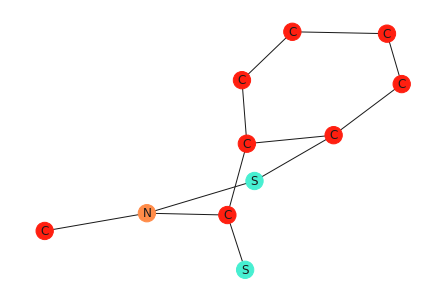

In [ ]:
#displaying one sample
plt.clf()
visualize(training_set[5])

#Trial One (No Upsampling)

> In this trial I will try all models without make the data balance to see if i make the data is balanced what will happend

## Preprocessing

In [ ]:
# #checking the labels of the training dataset
# labelss = []
# for sam in training_set:
#   labelss.append(sam[2])

# np.unique(labelss,return_counts=True)  

In [ ]:
# #checking the labels of the testing dataset
# labelss = []
# for sam in testing_set:
#   labelss.append(sam[2])
# np.unique(labelss,return_counts=True) 

In [ ]:
#vocabulary size
max_vocab = 500
# maximum length of the tokenized vector
max_len = 100 

# build vocabulary from training set only for nodes characters
all_nodes = [s[0] for s in training_set]

#training tokenizer
tokenizer = Tokenizer(num_words = max_vocab)
tokenizer.fit_on_texts(all_nodes)

> method to prepare single batch set

> samples represents the batch of data


Build a _preprocess function which assign integer value to each word in the sequence based on vocabulary and then transform into a matrix using pad_sequences from keras with

* vocab_size = 500
* max_len = 100
* padding = post
* truncationg = post


In [ ]:
random.seed(0)

def prepare_single_batch(samples):
  #nodes characters array
  sample_nodes = [s[0] for s in samples]
  #tokenizing the sample nodes
  sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
  #pad_sequences for each sample node with post padding and post truncating 
  sample_nodes = pad_sequences(sample_nodes, padding='post', truncating = 'pre')
  #maximum length of nodes 
  max_nodes_len = np.shape(sample_nodes)[1]
  #defining edges
  edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
  edges = [e for e in edges if len(e) > 0]

  #array definition for segmented_ids
  node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
  
  #reshaping as 1 vector
  all_nodes = np.reshape(sample_nodes, -1)
  #concatenating all the edges as size [total_edges ,2]
  all_edges = np.concatenate(edges)

  node_to_graph = np.reshape(node_to_graph, -1)
  #returns a dictionary of features(data,edges,node2grah) and label
  return {
      'data': all_nodes,
      'edges': all_edges,
      'node2grah': node_to_graph,
  }, np.array([s[2] for s in samples]) 

**generating batch with given btch_size method**

In [ ]:
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
      dataset = list(dataset)
      if shuffle:
        #randomly shuffling
        random.shuffle(dataset)
      
      #length of dataset
      l = len(dataset)
      #for creating batches from given dataset
      for ndx in range(0, l, batch_size):
        #creating batch samples with given batch_size
        batch_samples = dataset[ndx:min(ndx + batch_size, l)]
        #returning a generator with prepared batches
        yield prepare_single_batch(batch_samples)
        
      if not repeat:
          break

In [ ]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)        
        print("Shape is "+str(np.shape(v)))
        pass
    print('label', train_batch[1])
    break

data
Shape is (132,)
edges
Shape is (120, 2)
node2grah
Shape is (132,)
label [0 1 0 0]


##Virtualization Method

> This method for virtualization the results of each model

In [ ]:
def results_virt(history):

  # generate a figure containing 3 plots displayed horizontally
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,7))
  fig.suptitle('Model Results')
  
  #first plot
  # first we display the training price accuracy in red color VS. the validation price accuracy in blue color through the epochs
  ax1.plot(history.history['auc'], 'r')
  ax1.plot(history.history['val_auc'], 'b')
  ax1.set_title('model AUC')
  ax1.set_ylabel('AUC')
  ax1.set_xlabel('epochs')
  ax1.legend(['tr_price_auc', 'val_price_auc'])
  ax1.grid()

  #second plot
  # on this axis, we plot the price training loss in red color VS. the price validation loss in blue color through the epochs
  ax2.plot(history.history['loss'], 'r')
  ax2.plot(history.history['val_loss'], 'b')
  ax2.set_title('model loss')
  ax2.set_ylabel('loss')
  ax2.set_xlabel('epoch')
  ax2.legend(['tr_loss', 'val_loss'])
  ax2.grid()

# display the figure
  plt.show() 

## Trial_1_1 (Demo)

> To understand the dimensions:
Let's assume the batch contains 10 samples of data.
The nodes are tokenized using 44 dimension array that is each sample node is of shape [44]
Thus 10 samples are of shape [440] after applying get_batch method
node2graph is also of shape [440] like [0,0,0,0,0,...,1,1,1,1,....2,2,2,....] each number is repeated 44 times [0,0,0,0,... 44 times]
Lets assume edges are of size [257,2]

> The GNN layer takes a GNNInput named tuple as input, which encapsulates initial node features, adjacency lists, and auxiliary information.


> in this trial i will use the demo to see the results and my expectation to get good results

### build the model architecture

In [ ]:
#Input layer for nodes (tokenized text data)
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch

#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
#embedding layer over data with each token embedded as a vector
embeded = Embedding(tokenizer.num_words, 80)(data)


# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))
num_graph = tf.reduce_max(node2graph)+1  

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer is 32
params["hidden_dim"] = 32
#gnn layer with defined hyperparameters
gnn_layer = GNN(params)  
#gnn output layer 
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input) 

print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

print('mean:', avg)

#final dense layer with sigmoid
pred = Dense(1, activation='sigmoid')(avg)
#output shape: [batch_size,1]
print('pred:', pred)

#Building The Model 
#inputs is dictionary of data, edges, node2graph
#output: prediction value from dense layer
model = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")


### display the model Summary and architecture

In [ ]:
#printing summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max (TFOpLambda  ()                  0           ['input_3[0][0]']                
 )                                                                                                
                                                                                                  
 embedding (Embedding)          (None, 80)           40000       ['input_1[0][0]']            

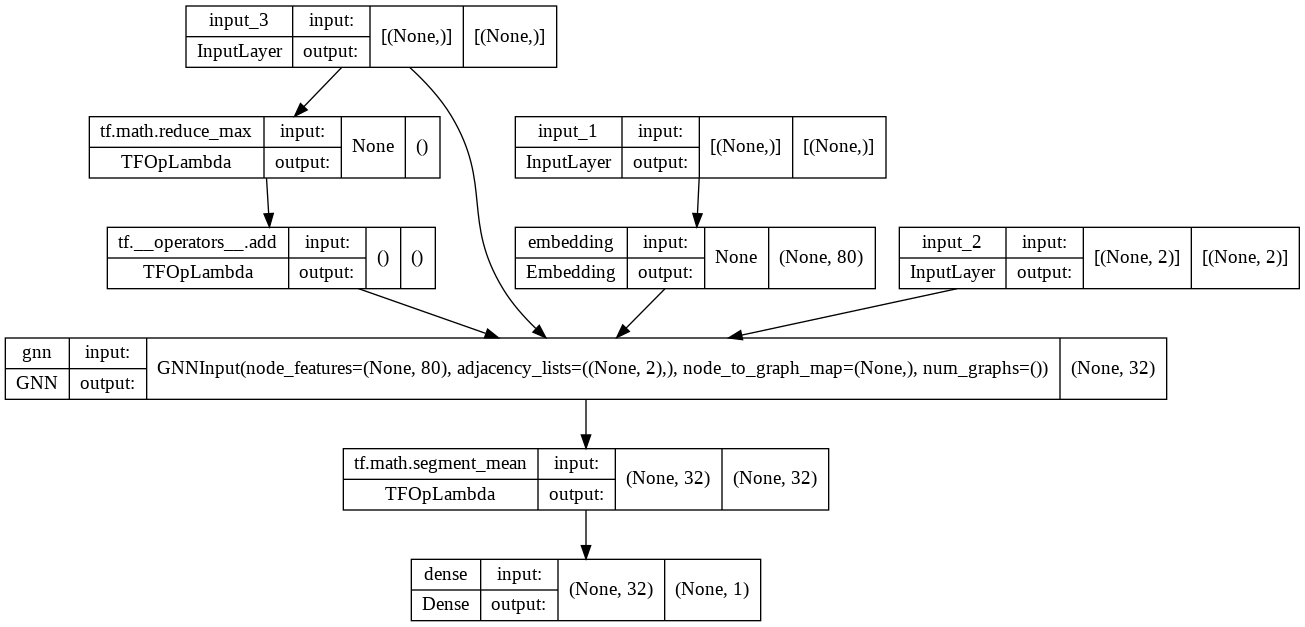

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

### compile and fit the model

in this trial i expect to get auc score around 80% for training and get 77% for validation because i didn't use a powerful model

In [ ]:
#I will create Adam Optimizer for training optimizer with this hyperparameters
ad = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)

In [ ]:
#compile the model by using my adam optimizer and BinaryCrossentropy loss
model.compile(
    optimizer = ad,
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
%%time
batch_size = 32
#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 19.1 µs


In [ ]:
#fit the models with 30 epoch and no early stopping
hist = model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1
)
print(hist)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a larg

626/626 [==============================] - 16s 20ms/step - loss: 0.2693 - auc: 0.4339 - val_loss: 0.2001 - val_auc: 0.5675
Epoch 2/30
626/626 [==============================] - 12s 19ms/step - loss: 0.1978 - auc: 0.5846 - val_loss: 0.1971 - val_auc: 0.5882
Epoch 3/30
626/626 [==============================] - 12s 19ms/step - loss: 0.1886 - auc: 0.6474 - val_loss: 0.2021 - val_auc: 0.6343
Epoch 4/30
626/626 [==============================] - 12s 20ms/step - loss: 0.1839 - auc: 0.6786 - val_loss: 0.1773 - val_auc: 0.7016
Epoch 5/30
626/626 [==============================] - 12s 19ms/step - loss: 0.1814 - auc: 0.6917 - val_loss: 0.1745 - val_auc: 0.7317
Epoch 6/30
626/626 [==============================] - 12s 19ms/step - loss: 0.1789 - auc: 0.7052 - val_loss: 0.1775 - val_auc: 0.7305
Epoch 7/30
626/626 [==============================] - 12s 20ms/step - loss: 0.1757 - auc: 0.7285 - val_loss: 0.1760 - val_auc: 0.7296
Epoch 8/30
626/626 [==============================] - 12s 19ms/step - los

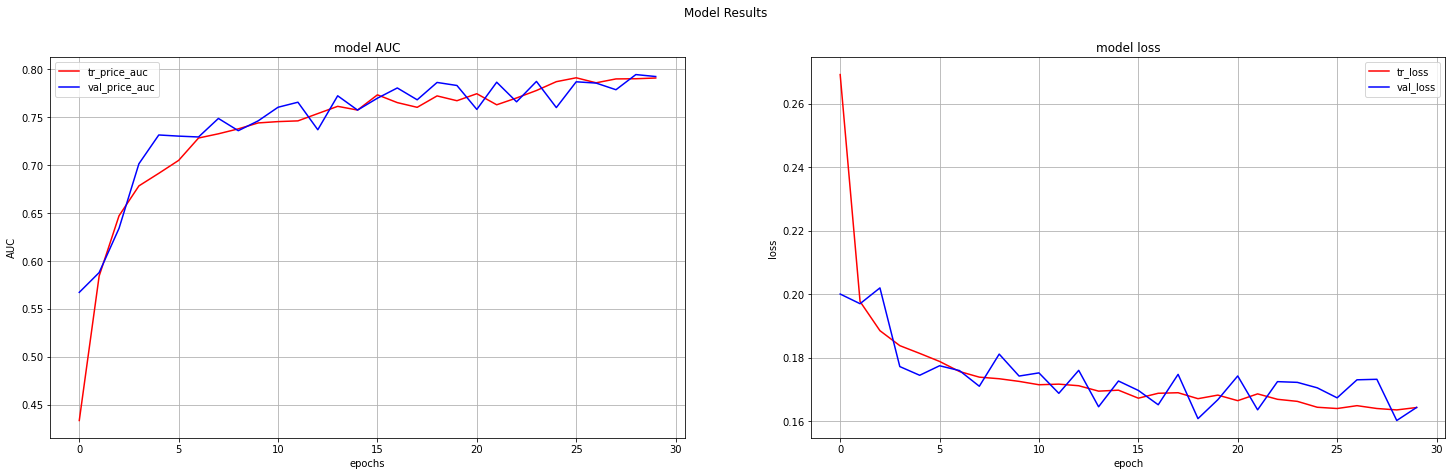

In [ ]:
#virtualize the results
results_virt(hist)

In [ ]:
#make a prediction by using the model
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [ ]:
#make a submission file to upload it on kaggle
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('Trial_1_1_50_32_79.csv')

#0.81299

> **As we see this model given me**
* around 80% training AUC score like i expected
* around 80% validation AUC score better than what i expected so it's good
* 81.3% score on kaggle which is good for first trial
* so this trial was good for the first trial i do which is not bad for the first trial but I will try anothr trial to see if the model will improve or not

> **my observation for this results**
* this model was good to reach this result as we see from the plots
* this model has this results because this model has normal architecture
* so this model hasn't overfitting and underfitting

##Trial_1_2 (GGNN)

> in this trial i will use the GGNN model with some dense layers to see if there is any improve or not

### build the model architecture

In [ ]:
#Input layer for nodes (tokenized text data)
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

#embedding layer over data with each token embedded as a vector   size vector eg. [440,75]
embeded = Embedding(tokenizer.num_words, 75)(data)

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))
num_graph = tf.reduce_max(node2graph)+1  

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
params["hidden_dim"] = 32 
params["message_calculation_class"] = 'GGNN'
#params["num_edge_MLP_hidden_layers"] = 16

#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 

#gnn output layer
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(8,activation='relu')(avg)
#fc2 = Dense(64,activation='relu')(fc1)

#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc1)
print('pred:', pred)

#Building The Model 
#inputs is dictionary of data, edges, node2graph
#output: prediction value from dense layer
model_2 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_1/SegmentMean:0', description="created by layer 'tf.math.segment_mean_1'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_2/Sigmoid:0', description="created by layer 'dense_2'")


### display the model Summary and architecture

In [ ]:
#printing summary of the model
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_1 (TFOpLamb  ()                  0           ['input_6[0][0]']                
 da)                                                                                              
                                                                                                  
 embedding_1 (Embedding)        (None, 75)           37500       ['input_4[0][0]']          

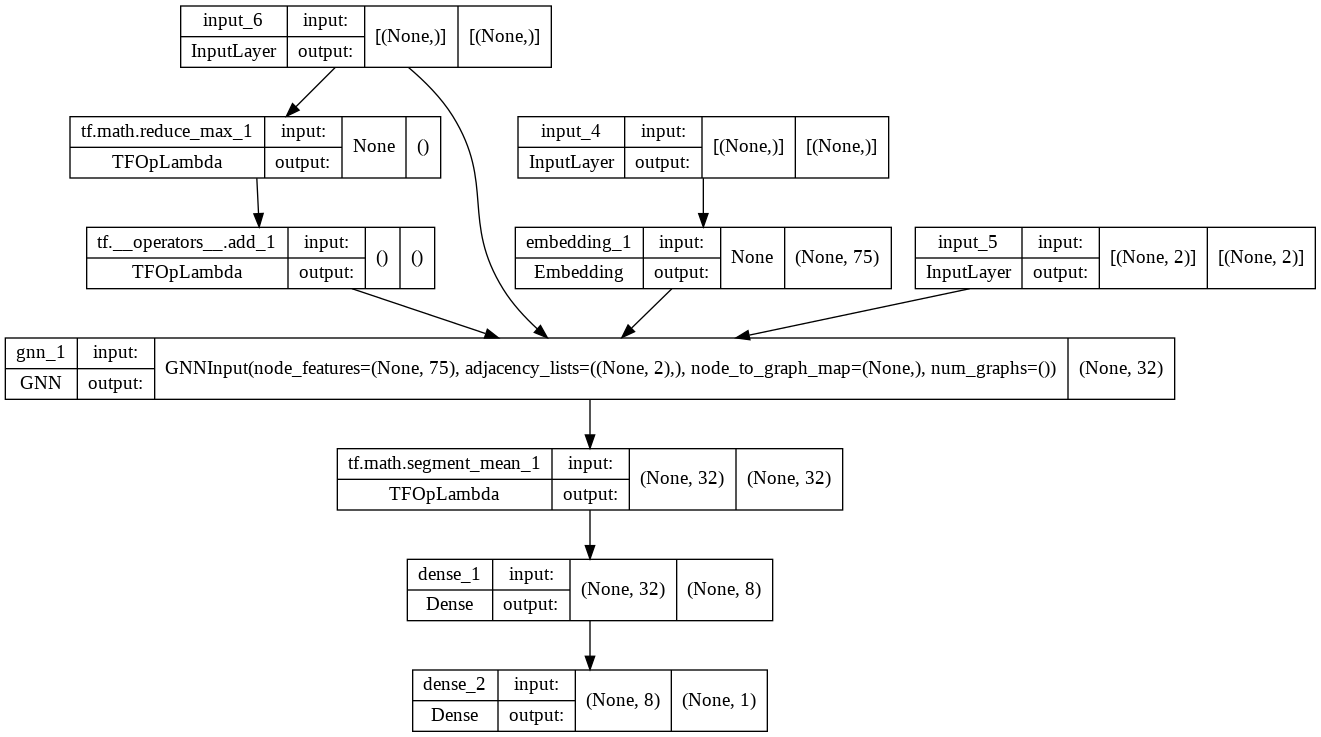

In [ ]:
tf.keras.utils.plot_model(model_2, show_shapes=True)

### compile and fit the model

in this trial i expect to get auc score around 85% for training and get 80% for validation because i make some improvement

In [ ]:
#I will create Adam Optimizer for training optimizer with this hyperparameters
ad = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)

In [ ]:
#compile the model by using my adam optimizer and BinaryCrossentropy loss
model_2.compile(
    optimizer = ad, 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 32

#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)

#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)



In [ ]:
#fit the models with 30 epoch and using early stopping to avoid overfitting
hist_2 = model_2.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
   callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3),
    verbose=1
)
print(hist_2)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/ggnn_3/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/ggnn_2/embedding_lookup_grad/Cast:0", s

626/626 [==============================] - 19s 25ms/step - loss: 0.2051 - auc: 0.5827 - val_loss: 0.1852 - val_auc: 0.6539
Epoch 2/30
626/626 [==============================] - 15s 25ms/step - loss: 0.1849 - auc: 0.6562 - val_loss: 0.1834 - val_auc: 0.6871
Epoch 3/30
626/626 [==============================] - 16s 25ms/step - loss: 0.1817 - auc: 0.6813 - val_loss: 0.1754 - val_auc: 0.7379
Epoch 4/30
626/626 [==============================] - 16s 25ms/step - loss: 0.1770 - auc: 0.7082 - val_loss: 0.1729 - val_auc: 0.7451
Epoch 5/30
626/626 [==============================] - 15s 24ms/step - loss: 0.1740 - auc: 0.7238 - val_loss: 0.1711 - val_auc: 0.7645
Epoch 6/30
626/626 [==============================] - 15s 24ms/step - loss: 0.1728 - auc: 0.7429 - val_loss: 0.1655 - val_auc: 0.7739
Epoch 7/30
626/626 [==============================] - 15s 24ms/step - loss: 0.1687 - auc: 0.7623 - val_loss: 0.1612 - val_auc: 0.7902
Epoch 8/30
626/626 [==============================] - 15s 24ms/step - los

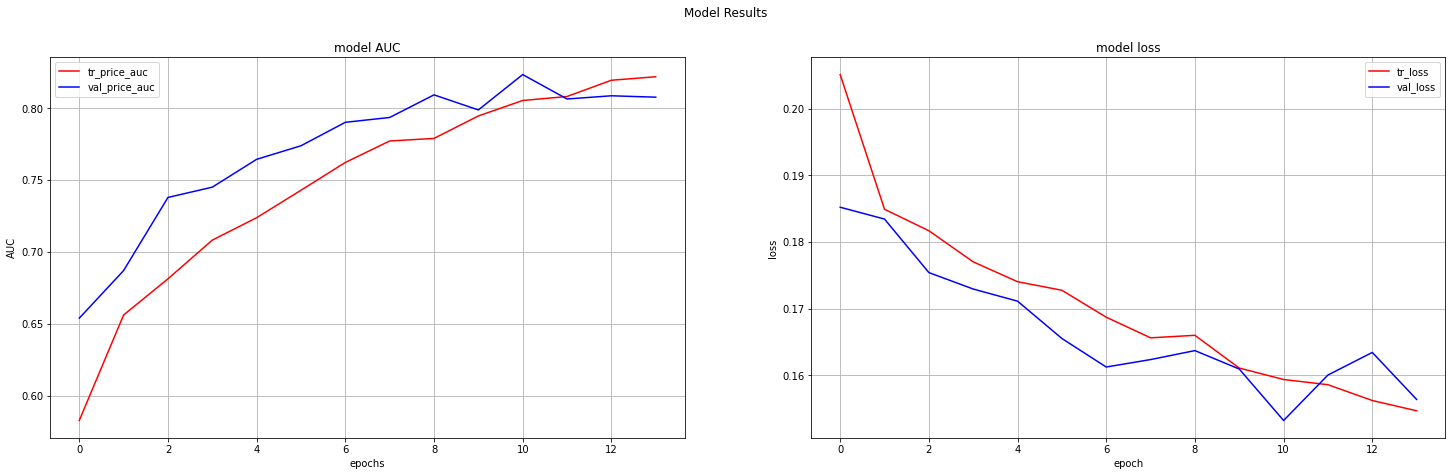

In [ ]:
#virtualize the results
results_virt(hist_2)

In [ ]:
#make a prediction by using the model
y_pred_2 = model_2.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred_2 = np.reshape(y_pred_2, -1)

In [ ]:
#make a submission file to upload it on kaggle
submission = pd.DataFrame({'label':y_pred_2})
submission.index.name = 'id'
submission.to_csv('trial_2_75_32_81.csv')

#0.81809

> **As we see this model given me**
* around 82% training AUC score less than what i expected
* around 80.7% validation AUC score better than what i expected so it's good
* 81.8% score on kaggle which is good
* so this trial was good trial but I will try anothr trial to see if the model will improve or not

> **my observation for this results**
* this model was good to reach this result as we see from the plots
* this model has this results because this model has normal architecture with some new layers
* so this model hasn't overfitting and underfitting

##Trial_1_3 (RGCN)

> in this trial i will use the RGCN model with some dense layers to see if there is any improve or not

### build the model architecture

In [ ]:
#Input layer for nodes (tokenized text data)
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

#embedding layer over data with each token embedded as a vector   size vector eg. [440,75]
embeded = Embedding(tokenizer.num_words, 70)(data)

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))
num_graph = tf.reduce_max(node2graph)+1  

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
params["hidden_dim"] = 32
params["message_calculation_class"] = 'RGCN'
#params["num_edge_MLP_hidden_layers"] = 16

#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 

#gnn output layer
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(64,activation='relu')(avg)
fc2 = Dense(32,activation='relu')(fc1)
d1 = Dropout(0.2)(fc2)

#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(d1)
print('pred:', pred)

#Building The Model 
#inputs is dictionary of data, edges, node2graph
#output: prediction value from dense layer
model_3 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_3/StatefulPartitionedCall:0', description="created by layer 'gnn_3'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_3/SegmentMean:0', description="created by layer 'tf.math.segment_mean_3'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_5/Sigmoid:0', description="created by layer 'dense_5'")


### display the model Summary and architecture

In [ ]:
#printing summary of the model
model_3.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_3 (TFOpLamb  ()                  0           ['input_12[0][0]']               
 da)                                                                                              
                                                                                                  
 embedding_3 (Embedding)        (None, 70)           35000       ['input_10[0][0]']         

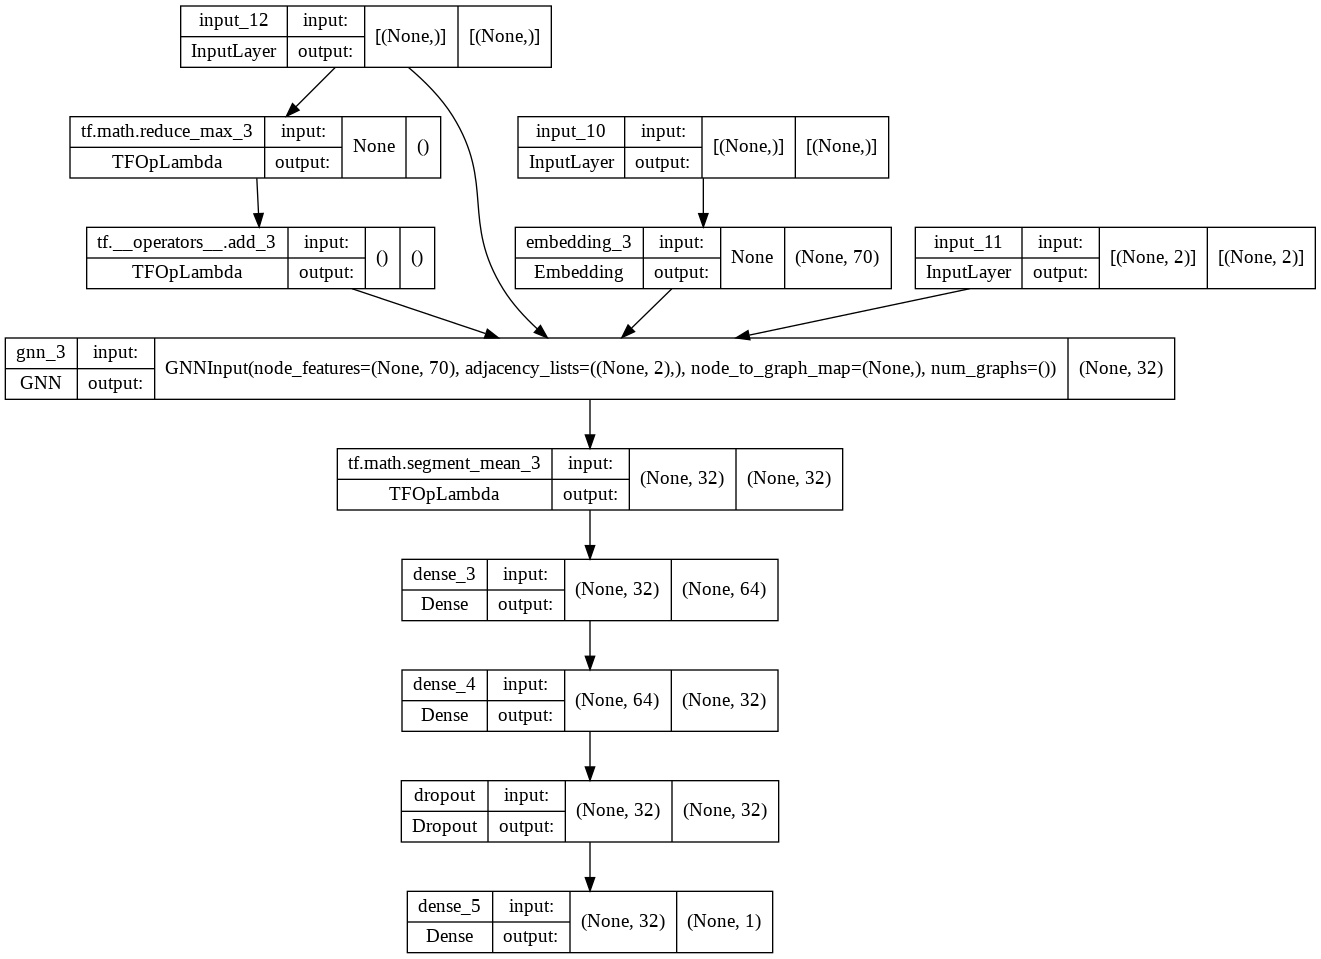

In [ ]:
tf.keras.utils.plot_model(model_3, show_shapes=True)

### compile and fit the model

in this trial i expect to get 
* auc score around 85% for training and get 
* 80% for validation 

because i make some improvement

In [ ]:
#compile the model by using adam optimizer and BinaryCrossentropy loss
model_3.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 32

#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)

#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)



In [ ]:
#fit the models with 30 epoch and using early stopping to avoid overfitting
hist_3 = model_3.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
  #  callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3),
    verbose=1
)
print(hist_3)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/rgcn_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor

626/626 [==============================] - 17s 22ms/step - loss: 0.2285 - auc: 0.5528 - val_loss: 0.1925 - val_auc: 0.6304
Epoch 2/30
626/626 [==============================] - 13s 20ms/step - loss: 0.1877 - auc: 0.6590 - val_loss: 0.1876 - val_auc: 0.6332
Epoch 3/30
626/626 [==============================] - 13s 21ms/step - loss: 0.1823 - auc: 0.6901 - val_loss: 0.1873 - val_auc: 0.6720
Epoch 4/30
626/626 [==============================] - 13s 20ms/step - loss: 0.1812 - auc: 0.7047 - val_loss: 0.1814 - val_auc: 0.6653
Epoch 5/30
626/626 [==============================] - 15s 23ms/step - loss: 0.1795 - auc: 0.7156 - val_loss: 0.1778 - val_auc: 0.6998
Epoch 6/30
626/626 [==============================] - 13s 20ms/step - loss: 0.1777 - auc: 0.7165 - val_loss: 0.1835 - val_auc: 0.6793
Epoch 7/30
626/626 [==============================] - 14s 22ms/step - loss: 0.1767 - auc: 0.7221 - val_loss: 0.1800 - val_auc: 0.6906
Epoch 8/30
626/626 [==============================] - 13s 20ms/step - los

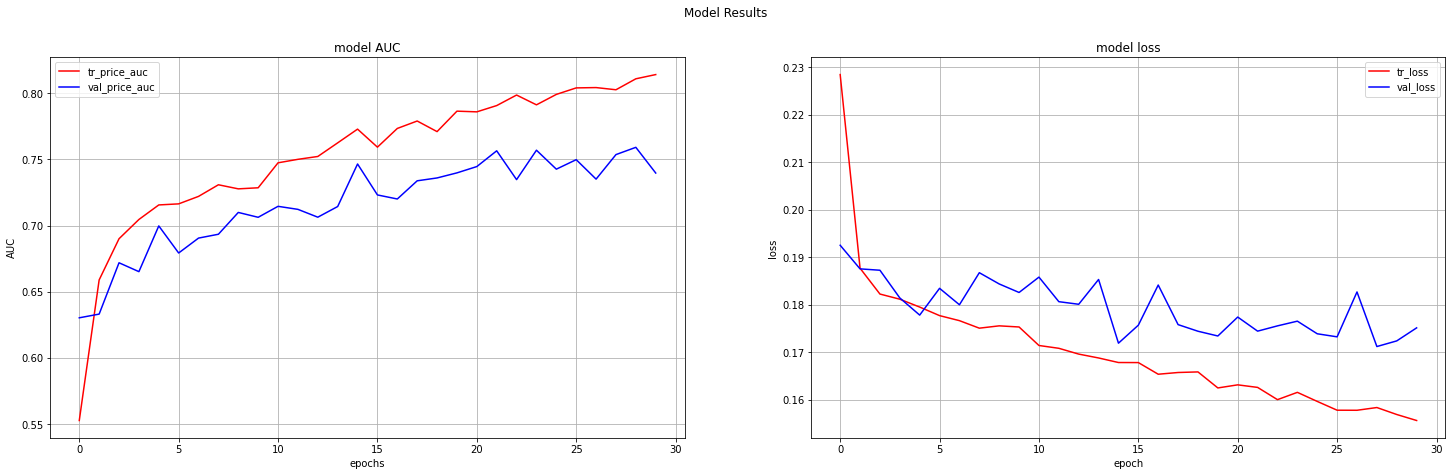

In [ ]:
#virtualize the results
results_virt(hist_3)

In [ ]:
#make a prediction by using the model
y_pred_3 = model_3.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred_3 = np.reshape(y_pred_3, -1)

In [ ]:
#make a submission file to upload it on kaggle
submission = pd.DataFrame({'label':y_pred_3})
submission.index.name = 'id'
submission.to_csv('trial_5_RGCN.csv')

#0.79382

> **As we see this model given me**
* around 81.5% training AUC score less than what i expected which so bad
* around 74% validation AUC score less than what i expected so it's not good
* 79.3% score on kaggle which is good
* so this trial was not bad and not good trial but I will try anothr trial to see if the model will improve or not

> **my observation for this results**
* this model was not good to reach this result as we see from the plots
* maybe that's happend because of i use very simple architecture so i will try another model with good architecture
* so this model hasn't overfitting and underfitting was gooing to overfitting

##Trial_1_4 (RGAT)

> in this trial i will use the RGCN model with some dense layers to see if there is any improve or not

### build the model architecture

In [ ]:
#Input layer for nodes (tokenized text data)
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

#embedding layer over data with each token embedded as a vector   size vector eg. [440,75]
embeded = Embedding(tokenizer.num_words, 70)(data)

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))
num_graph = tf.reduce_max(node2graph)+1  

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
params["hidden_dim"] = 32
params["message_calculation_class"] = 'RGAT'
params["num_edge_MLP_hidden_layers"] = 16
params["num_heads"] = 16
# params["num_layers"] = 4
# params["dense_every_num_layers"] = 4



#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 

#gnn output layer
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(64,activation='relu')(avg)
fc2 = Dense(32,activation='relu')(fc1)
# d1 = Dropout(0.2)(fc2)

#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc2)
print('pred:', pred)

#Building The Model 
#inputs is dictionary of data, edges, node2graph
#output: prediction value from dense layer
model_4 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_13/StatefulPartitionedCall:0', description="created by layer 'gnn_13'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_9/SegmentMean:0', description="created by layer 'tf.math.segment_mean_9'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_24/Sigmoid:0', description="created by layer 'dense_24'")


### display the model Summary and architecture

In [ ]:
#printing summary of the model
model_4.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_40 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_13 (TFOpLam  ()                  0           ['input_42[0][0]']               
 bda)                                                                                             
                                                                                                  
 embedding_13 (Embedding)       (None, 70)           35000       ['input_40[0][0]']         

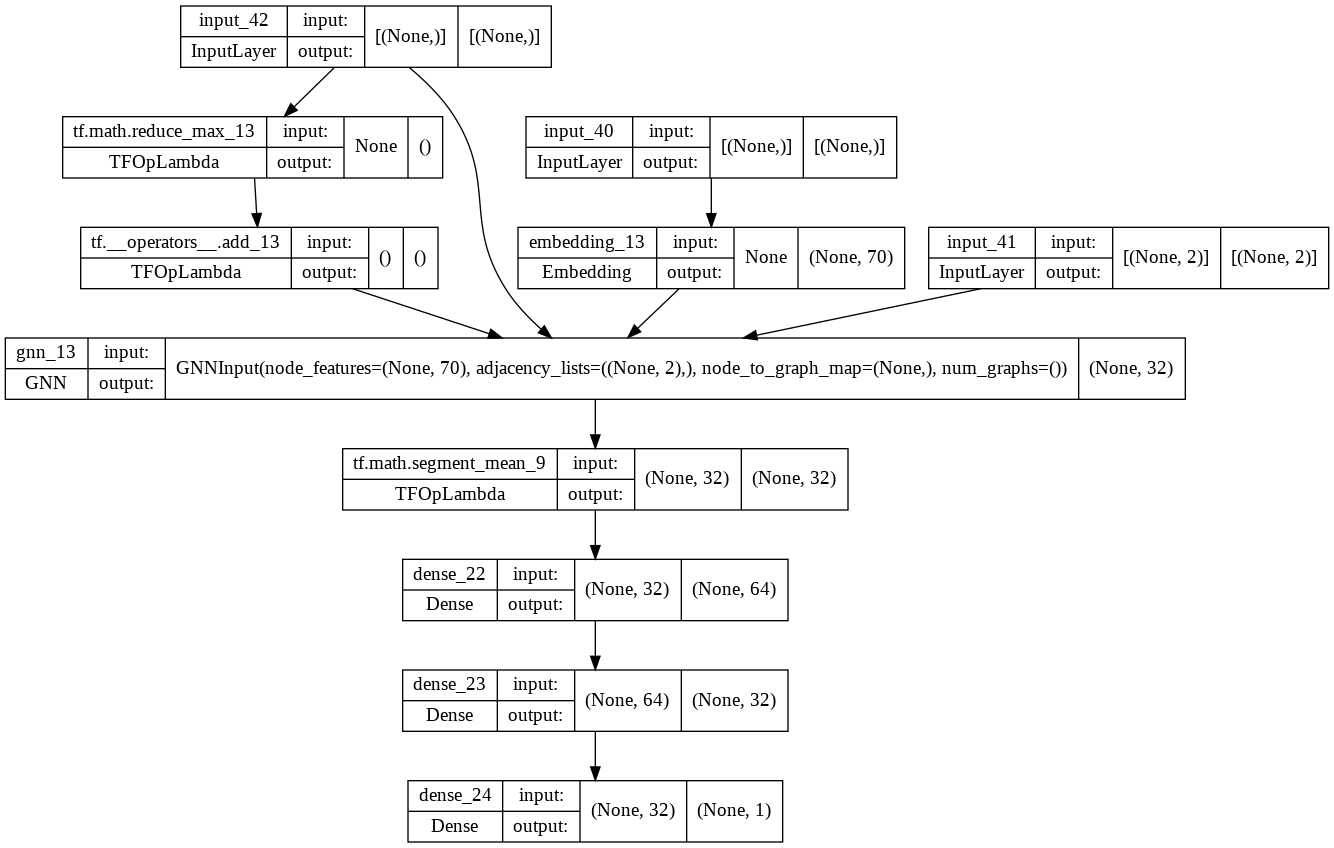

In [ ]:
tf.keras.utils.plot_model(model_4, show_shapes=True)

### compile and fit the model

in this trial i expect to get 
* auc score around 85% for training and get 
* 80% for validation 

because i make some improvement

In [ ]:
#compile the model by using adam optimizer and BinaryCrossentropy loss
model_4.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 32

#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)

#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)



In [ ]:
#fit the models with 30 epoch and using early stopping to avoid overfitting
hist_4 = model_4.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
  #  callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3),
    # verbose=1
)
print(hist_4)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/concat_3:0", shape=(None,), dtype=int32), values=Tensor("gradients/concat_2:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/rgat_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memo

626/626 [==============================] - 64s 84ms/step - loss: 0.2334 - auc: 0.5253 - val_loss: 0.1916 - val_auc: 0.6128
Epoch 2/30
626/626 [==============================] - 51s 82ms/step - loss: 0.1852 - auc: 0.6630 - val_loss: 0.1884 - val_auc: 0.6430
Epoch 3/30
626/626 [==============================] - 52s 82ms/step - loss: 0.1801 - auc: 0.6962 - val_loss: 0.1912 - val_auc: 0.6813
Epoch 4/30
626/626 [==============================] - 51s 82ms/step - loss: 0.1778 - auc: 0.7190 - val_loss: 0.1831 - val_auc: 0.6965
Epoch 5/30
626/626 [==============================] - 51s 82ms/step - loss: 0.1735 - auc: 0.7430 - val_loss: 0.1771 - val_auc: 0.7210
Epoch 6/30
626/626 [==============================] - 51s 82ms/step - loss: 0.1715 - auc: 0.7499 - val_loss: 0.1835 - val_auc: 0.7235
Epoch 7/30
626/626 [==============================] - 51s 81ms/step - loss: 0.1697 - auc: 0.7671 - val_loss: 0.1759 - val_auc: 0.7361
Epoch 8/30
626/626 [==============================] - 51s 82ms/step - los

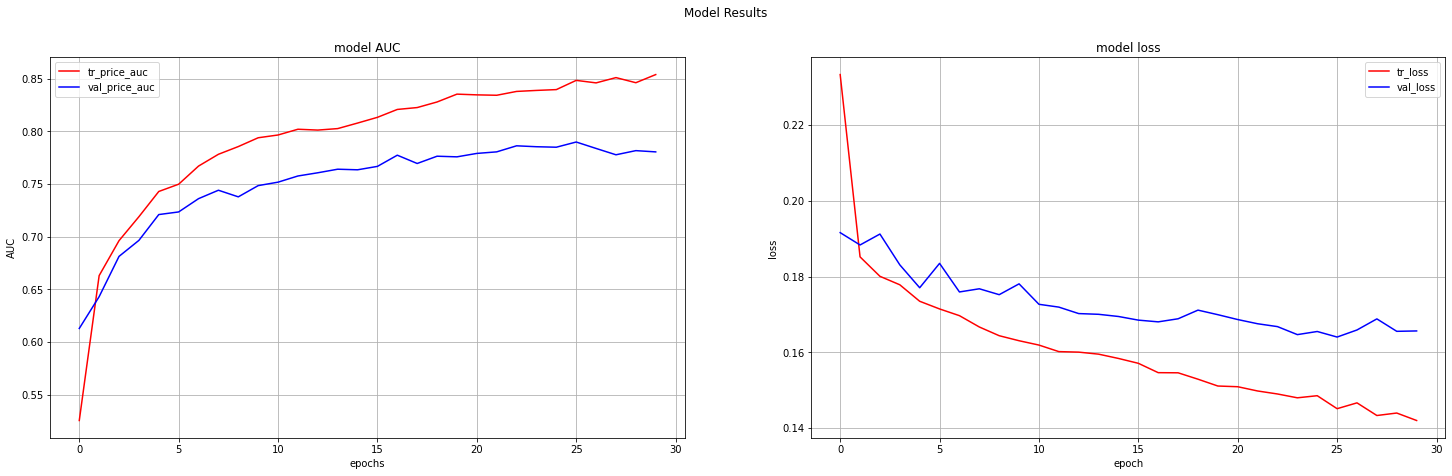

In [ ]:
#virtualize the results
results_virt(hist_4)

In [ ]:
#make a prediction by using the model
y_pred_4 = model_4.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred_4 = np.reshape(y_pred_4, -1)

In [ ]:
#make a submission file to upload it on kaggle
submission = pd.DataFrame({'label':y_pred_4})
submission.index.name = 'id'
submission.to_csv('trial_4_RGAT.csv')

#kaggle ==> 0.83760

> **As we see this model given me**
* around 85.5% training AUC score more than what i expected which so good
* around 78% validation AUC score less than what i expected but still good
* 83.8% score on kaggle which is good
* so this trial is the best trial utill now but I will try anothr trial to see if the model will improve or not

> **my observation for this results**
* this model was good to reach this result as we see from the plots
* this model hadn't overfitting or underfitting

##Trial_1_5 (RGIN)

> in this trial i will use the RGIN model with some dense layers to see if there is any improve or not

### build the model architecture

In [ ]:
#Input layer for nodes (tokenized text data)
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

#embedding layer over data with each token embedded as a vector   size vector eg. [440,75]
embeded = Embedding(tokenizer.num_words, 100)(data)

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))
num_graph = tf.reduce_max(node2graph)+1  

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
params["hidden_dim"] = 32
params["message_calculation_class"] = 'RGIN'
params["num_aggr_MLP_hidden_layers"] = 1
# params["num_edge_MLP_hidden_layers"] = 16
params["num_heads"] = 16
# params["num_layers"] = 4
# params["dense_every_num_layers"] = 4



#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 

#gnn output layer
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(64,activation='relu')(avg)
fc2 = Dense(32,activation='relu')(fc1)
# d1 = Dropout(0.2)(fc2)

#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc2)
print('pred:', pred)

#Building The Model 
#inputs is dictionary of data, edges, node2graph
#output: prediction value from dense layer
model_5 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_17/StatefulPartitionedCall:0', description="created by layer 'gnn_17'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_12/SegmentMean:0', description="created by layer 'tf.math.segment_mean_12'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_33/Sigmoid:0', description="created by layer 'dense_33'")


### display the model Summary and architecture

In [ ]:
#printing summary of the model
model_5.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_54 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_52 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_17 (TFOpLam  ()                  0           ['input_54[0][0]']               
 bda)                                                                                             
                                                                                                  
 embedding_17 (Embedding)       (None, 100)          50000       ['input_52[0][0]']        

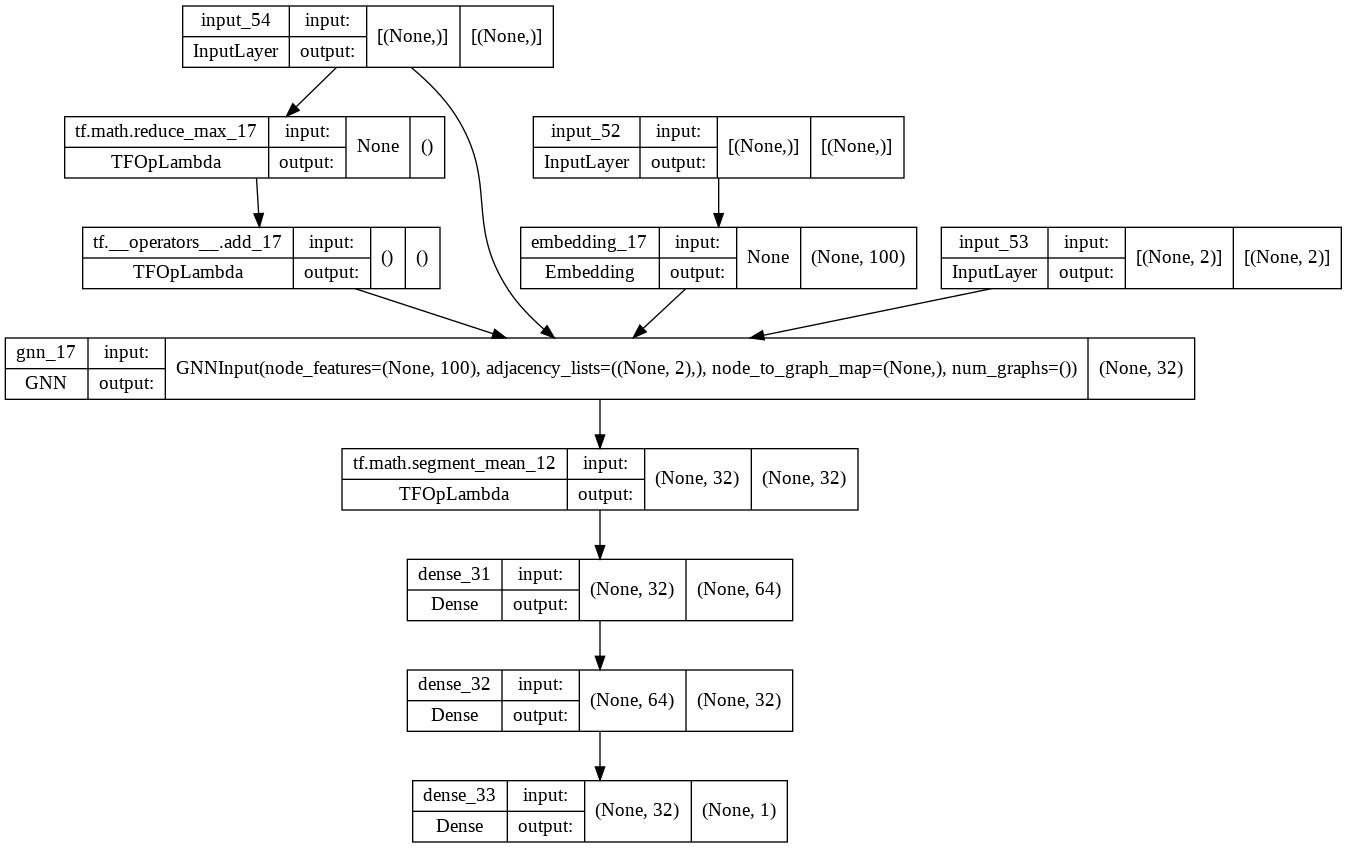

In [ ]:
tf.keras.utils.plot_model(model_5, show_shapes=True)

### compile and fit the model

in this trial i expect to get 
* auc score around 85% for training and get 
* 80% for validation 

because i make some improvement

In [ ]:
#compile the model by using adam optimizer and BinaryCrossentropy loss
model_5.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 32

#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)

#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)



In [ ]:
#fit the models with 30 epoch and using early stopping to avoid overfitting
hist_5 = model_5.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
  #  callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3),
    # verbose=1
)
print(hist_5)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgin_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgin_2/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/rgin_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor

626/626 [==============================] - 18s 24ms/step - loss: 0.2255 - auc: 0.5597 - val_loss: 0.1859 - val_auc: 0.6444
Epoch 2/30
626/626 [==============================] - 14s 23ms/step - loss: 0.1831 - auc: 0.6824 - val_loss: 0.1858 - val_auc: 0.6424
Epoch 3/30
626/626 [==============================] - 15s 23ms/step - loss: 0.1790 - auc: 0.7064 - val_loss: 0.1892 - val_auc: 0.6654
Epoch 4/30
626/626 [==============================] - 14s 23ms/step - loss: 0.1780 - auc: 0.7197 - val_loss: 0.1852 - val_auc: 0.6700
Epoch 5/30
626/626 [==============================] - 14s 23ms/step - loss: 0.1773 - auc: 0.7161 - val_loss: 0.1820 - val_auc: 0.6865
Epoch 6/30
626/626 [==============================] - 15s 23ms/step - loss: 0.1755 - auc: 0.7263 - val_loss: 0.1834 - val_auc: 0.6918
Epoch 7/30
626/626 [==============================] - 15s 23ms/step - loss: 0.1760 - auc: 0.7212 - val_loss: 0.1786 - val_auc: 0.6909
Epoch 8/30
626/626 [==============================] - 14s 23ms/step - los

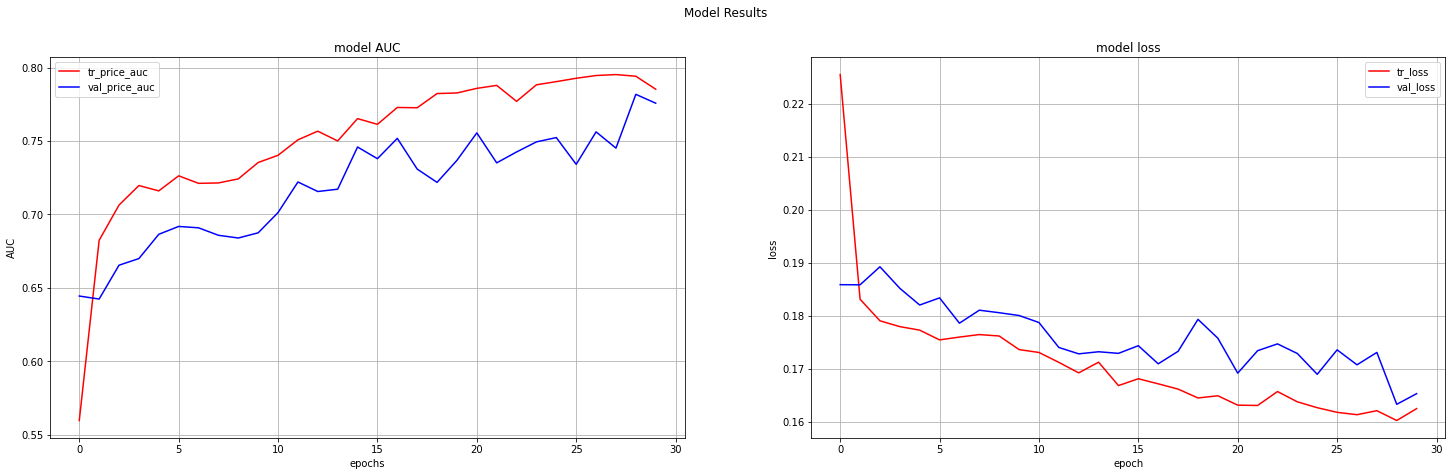

In [ ]:
#virtualize the results
results_virt(hist_5)

In [ ]:
#make a prediction by using the model
y_pred_5 = model_5.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred_5 = np.reshape(y_pred_5, -1)

In [ ]:
#make a submission file to upload it on kaggle
submission = pd.DataFrame({'label':y_pred_5})
submission.index.name = 'id'
submission.to_csv('trial_5_RGIN.csv')

#kaggle ==> 0.78275

> **As we see this model given me**
* around 78.5% training AUC score less than what i expected which so bad
* around 77.5% validation AUC score less than what i expected
* 78.2% score on kaggle which is bad
* so this trial is not good trial but I will try anothr trial to see if the model will improve or not

> **my observation for this results**
* this model was good to reach this result as we see from the plots
* this model hadn't overfitting or underfitting
* this model was so slow to reach this results which is not good

##Trial_1_6 (GNN-Edge-ML)

### build the model architecture

In [ ]:
#Input layer for nodes (tokenized text data)
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

#embedding layer over data with each token embedded as a vector   size vector eg. [440,75]
embeded = Embedding(tokenizer.num_words, 80)(data)

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))
num_graph = tf.reduce_max(node2graph)+1  

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
params["hidden_dim"] = 40
params["message_calculation_class"] = 'gnn_edge_mlp'
params["num_aggr_MLP_hidden_layers"] = 4
params["num_edge_MLP_hidden_layers"] = 4
params["num_heads"] = 4
params["num_layers"] = 4
params["dense_every_num_layers"] = 4



#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 

#gnn output layer
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(64,activation='relu')(avg)
fc2 = Dense(32,activation='relu')(fc1)
# d1 = Dropout(0.2)(fc2)

#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc2)
print('pred:', pred)

#Building The Model 
#inputs is dictionary of data, edges, node2graph
#output: prediction value from dense layer
model_6 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='gnn_24/StatefulPartitionedCall:0', description="created by layer 'gnn_24'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='tf.math.segment_mean_18/SegmentMean:0', description="created by layer 'tf.math.segment_mean_18'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_51/Sigmoid:0', description="created by layer 'dense_51'")


### display the model Summary and architecture

In [ ]:
#printing summary of the model
model_6.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_75 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_73 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_24 (TFOpLam  ()                  0           ['input_75[0][0]']               
 bda)                                                                                             
                                                                                                  
 embedding_24 (Embedding)       (None, 80)           40000       ['input_73[0][0]']        

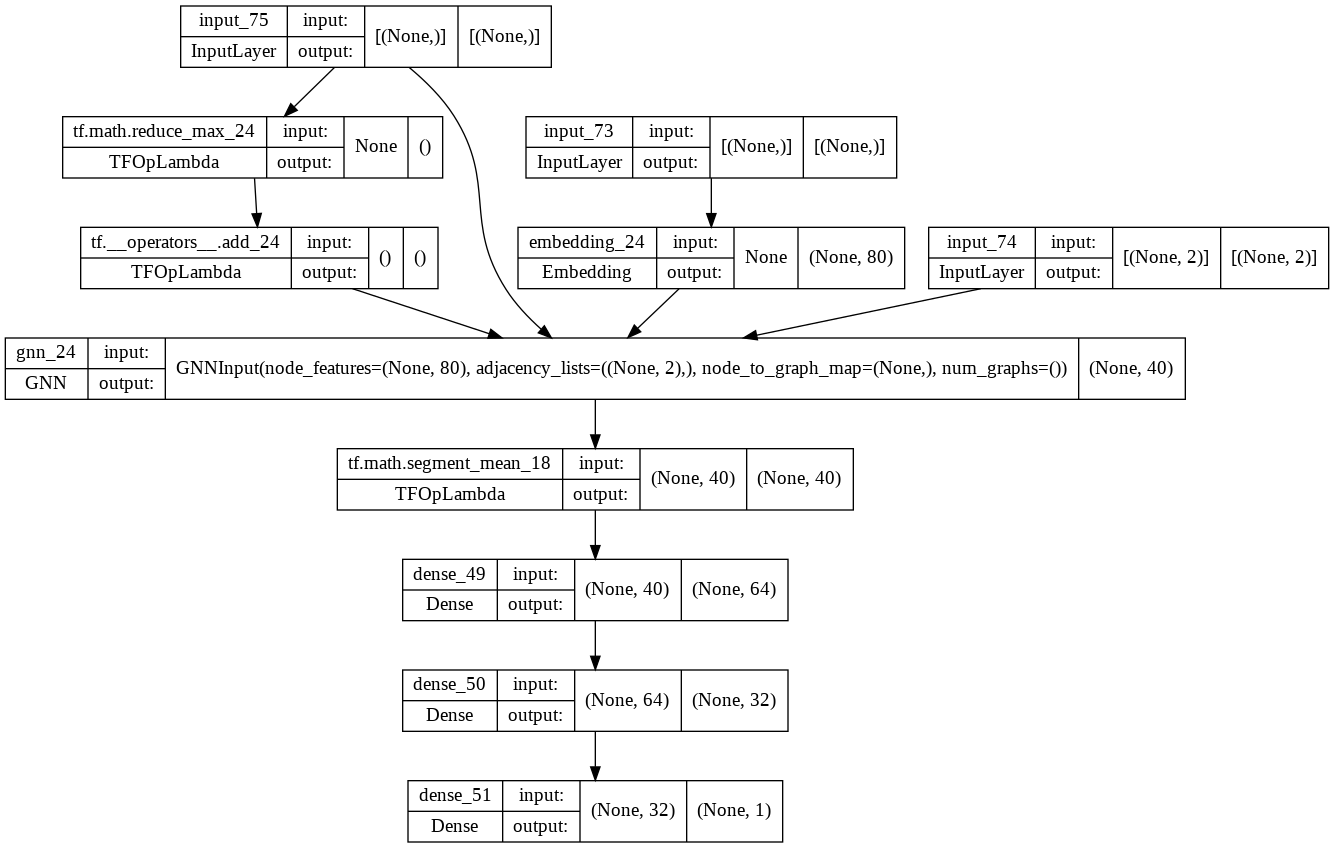

In [ ]:
tf.keras.utils.plot_model(model_6, show_shapes=True)

### compile and fit the model

in this trial i expect to get 
* auc score around 85% for training and get 
* 80% for validation 

because i make some improvement

In [ ]:
#compile the model by using adam optimizer and BinaryCrossentropy loss
model_6.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 32

#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)

#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)



In [ ]:
#fit the models with 30 epoch and using early stopping to avoid overfitting
hist_6 = model_6.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
  #  callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3),
    # verbose=1
)
print(hist_6)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 40), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/gnn__edge_mlp_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/gnn__edge_mlp_2/embedding_lookup_grad/Reshape:0", shape=(None, 40), dtype=float32), dense_shape=Tensor("gradients/gnn__edge_mlp_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype

626/626 [==============================] - 20s 26ms/step - loss: 0.2314 - auc: 0.5531 - val_loss: 0.1959 - val_auc: 0.6007
Epoch 2/30
626/626 [==============================] - 16s 25ms/step - loss: 0.1868 - auc: 0.6634 - val_loss: 0.1889 - val_auc: 0.6420
Epoch 3/30
626/626 [==============================] - 16s 25ms/step - loss: 0.1837 - auc: 0.6876 - val_loss: 0.1898 - val_auc: 0.6441
Epoch 4/30
626/626 [==============================] - 16s 25ms/step - loss: 0.1788 - auc: 0.7055 - val_loss: 0.1855 - val_auc: 0.6660
Epoch 5/30
626/626 [==============================] - 16s 25ms/step - loss: 0.1777 - auc: 0.7125 - val_loss: 0.1814 - val_auc: 0.6790
Epoch 6/30
626/626 [==============================] - 16s 25ms/step - loss: 0.1767 - auc: 0.7159 - val_loss: 0.1814 - val_auc: 0.6727
Epoch 7/30
626/626 [==============================] - 16s 26ms/step - loss: 0.1750 - auc: 0.7207 - val_loss: 0.1828 - val_auc: 0.6780
Epoch 8/30
626/626 [==============================] - 16s 25ms/step - los

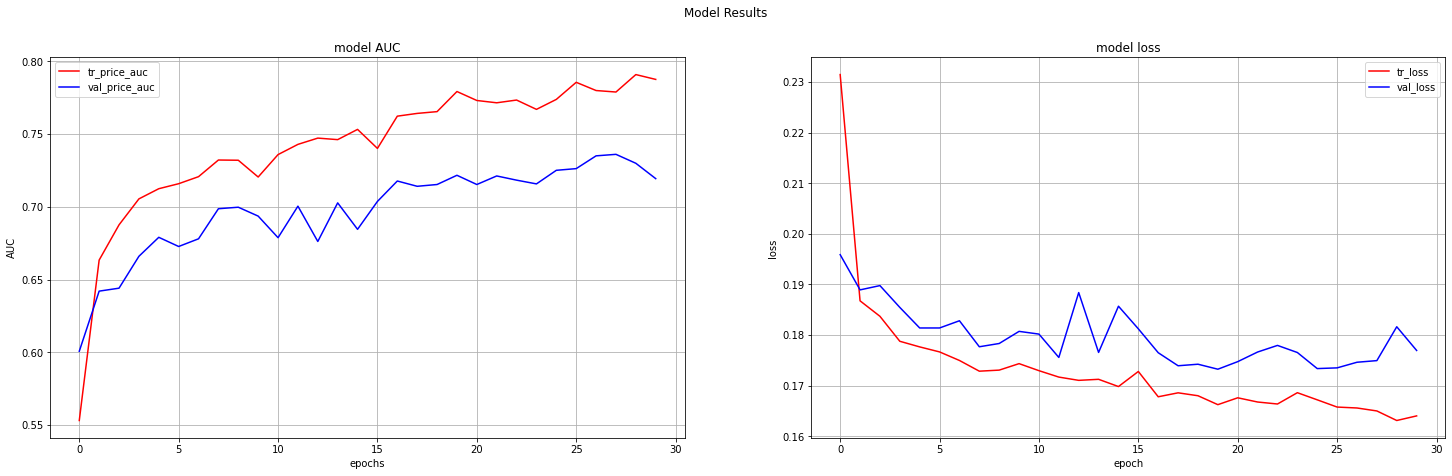

In [ ]:
#virtualize the results
results_virt(hist_6)

In [ ]:
#make a prediction by using the model
y_pred_6 = model_6.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred_6 = np.reshape(y_pred_6, -1)

In [ ]:
#make a submission file to upload it on kaggle
submission = pd.DataFrame({'label':y_pred_6})
submission.index.name = 'id'
submission.to_csv('trial_6_GNN-Edge-ML.csv')

#kaggle ==> 0.75852

> **As we see this model given me**
* around 78.8% training AUC score less than what i expected which so bad
* around 72% validation AUC score less than what i expected which so bad
* around 76% score on kaggle which is bad
* so this trial is not good trial but I will try anothr trial to see if the model will improve or not

> **my observation for this results**
* this model was good to reach this result as we see from the plots
* this model hadn't overfitting or underfitting but was going to overfitting if the model run more than 30 epochs

##Trial_1_7 (GNN-FiLM)

### build the model architecture

In [ ]:
#Input layer for nodes (tokenized text data)
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

#embedding layer over data with each token embedded as a vector   size vector eg. [440,75]
embeded = Embedding(tokenizer.num_words, 80)(data)

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))
num_graph = tf.reduce_max(node2graph)+1  

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
params["hidden_dim"] = 40
params["message_calculation_class"] = 'GNN_FiLM'
params["num_aggr_MLP_hidden_layers"] = 2
params["num_edge_MLP_hidden_layers"] = 2
params["num_heads"] = 4
params["num_layers"] = 4
params["dense_every_num_layers"] = 1
params["film_parameter_MLP_hidden_layers"] = 1



#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 

#gnn output layer
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(128,activation='relu')(avg)
fc2 = Dense(64,activation='relu')(fc1)
# d1 = Dropout(0.2)(fc2)

#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc2)
print('pred:', pred)

#Building The Model 
#inputs is dictionary of data, edges, node2graph
#output: prediction value from dense layer
model_7 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='gnn_5/StatefulPartitionedCall:0', description="created by layer 'gnn_5'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='tf.math.segment_mean_5/SegmentMean:0', description="created by layer 'tf.math.segment_mean_5'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_17/Sigmoid:0', description="created by layer 'dense_17'")


### display the model Summary and architecture

In [ ]:
#printing summary of the model
model_7.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_5 (TFOpLamb  ()                  0           ['input_18[0][0]']               
 da)                                                                                              
                                                                                                  
 embedding_5 (Embedding)        (None, 80)           40000       ['input_16[0][0]']         

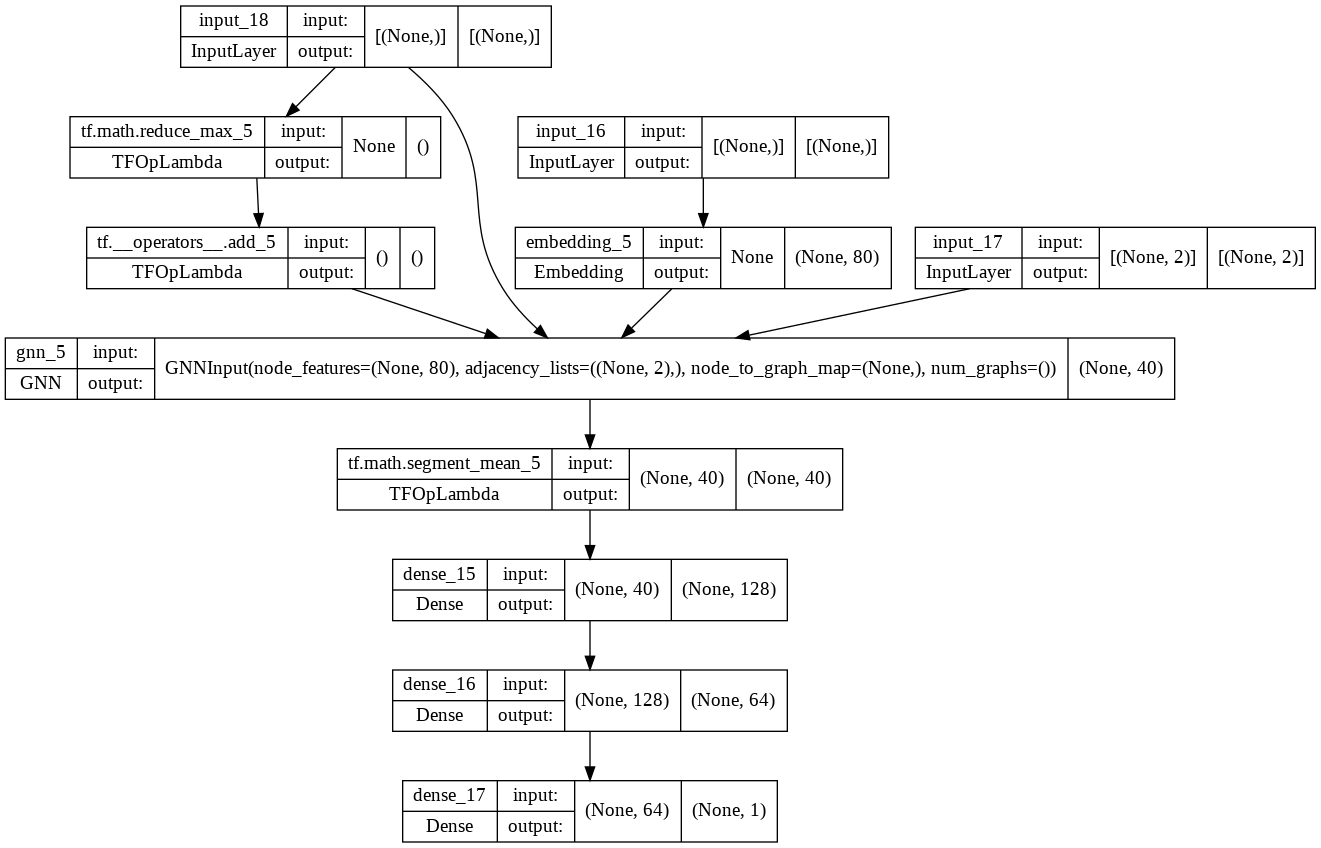

In [ ]:
tf.keras.utils.plot_model(model_7, show_shapes=True)

### compile and fit the model

in this trial i expect to get 
* auc score around 85% for training and get 
* 80% for validation 

because i make some improvement

In [ ]:
#compile the model by using adam optimizer and BinaryCrossentropy loss
model_7.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 32

#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)

#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)



In [ ]:
#fit the models with 30 epoch and using early stopping to avoid overfitting
hist_7 = model_7.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
  #  callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3),
    # verbose=1
)
print(hist_7)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 40), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/concat_3:0", shape=(None,), dtype=int32), values=Tensor("gradients/concat_2:0", shape=(None, 40), dtype=float32), dense_shape=Tensor("gradients/gnn__fi_lm_2/embedding_lookup_1_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount

626/626 [==============================] - 13s 16ms/step - loss: 0.2253 - auc: 0.4970 - val_loss: 0.1758 - val_auc: 0.6277
Epoch 2/30
626/626 [==============================] - 9s 15ms/step - loss: 0.1870 - auc: 0.6614 - val_loss: 0.1712 - val_auc: 0.6759
Epoch 3/30
626/626 [==============================] - 10s 15ms/step - loss: 0.1815 - auc: 0.6849 - val_loss: 0.1613 - val_auc: 0.6937
Epoch 4/30
626/626 [==============================] - 10s 15ms/step - loss: 0.1774 - auc: 0.7273 - val_loss: 0.1628 - val_auc: 0.7111
Epoch 5/30
626/626 [==============================] - 9s 15ms/step - loss: 0.1762 - auc: 0.7361 - val_loss: 0.1604 - val_auc: 0.7384
Epoch 6/30
626/626 [==============================] - 10s 16ms/step - loss: 0.1727 - auc: 0.7598 - val_loss: 0.1597 - val_auc: 0.7382
Epoch 7/30
626/626 [==============================] - 9s 15ms/step - loss: 0.1722 - auc: 0.7627 - val_loss: 0.1660 - val_auc: 0.6989
Epoch 8/30
626/626 [==============================] - 10s 15ms/step - loss: 

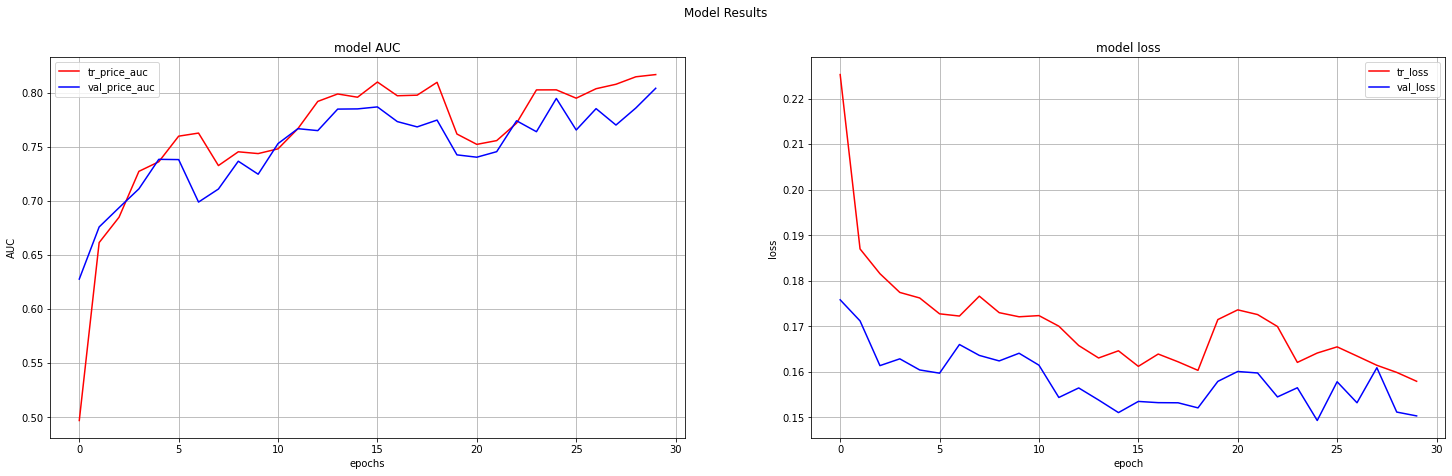

In [ ]:
#virtualize the results
results_virt(hist_7)

In [ ]:
#make a prediction by using the model
y_pred_7 = model_7.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred_7 = np.reshape(y_pred_7, -1)

In [ ]:
#make a submission file to upload it on kaggle
submission = pd.DataFrame({'label':y_pred_7})
submission.index.name = 'id'
submission.to_csv('trial_7_GNN_FiLM.csv')

#kaggle ==> 0.82299

> **As we see this model given me**
* around 82% training AUC score less than what i expected
* around 80.5% validation AUC score look like what i expected which is good
* 82.3% score on kaggle which is good
* so this trial is good but not the best one but I will try anothr trial to see if the model will improve or not

> **my observation for this results**
* this model was good to reach this result as we see from the plots
* this model hadn't overfitting or underfitting
* this model was so fast to reach this results which is not good
* this is the good model i built to reach this results

#Trial Two (Upsampling)

> **In this trial, I will manipulate the data to make the data balanced**

##Upsampling

> In this part, I will do data resample to achieve data balance

Read the data 

In [ ]:
#reading train.sdf file
training_set_T2 = read_sdf('train.sdf')

  0%|          | 0/25024 [00:00<?, ?it/s]

In [ ]:
#checking for data balancing
np.unique(np.array(training_set_T2)[:,2],return_counts=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


(array([0, 1], dtype=object), array([23806,  1218]))

In [ ]:
#specify the length of the maximum freqent data to make the both labels have the same number of sample
len_0 = np.unique(np.array(training_set_T2)[:,2],return_counts=True)[1][0]
len_0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


23806

In [ ]:
#convert the data from List to DataFrame to make upsampling
data = pd.DataFrame(np.array(training_set_T2)[:,:], columns = ['0', '1', 'target'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
#checking for the number of index in the data before and after converting
len(data) == len(training_set_T2)

True

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


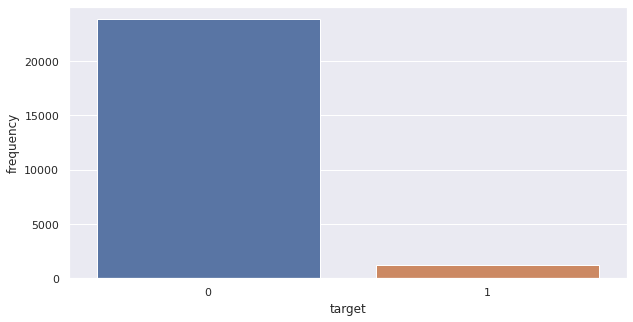

In [ ]:
#checking for the distribution of target data
fig, ax = plt.subplots(figsize = (10, 5))
sns.countplot('target', data = data, order = data['target'].value_counts().index, ax = ax)
ax.set(xlabel='target', ylabel='frequency')
plt.show()

Using resample method to make upsampling

In [ ]:
from sklearn.utils import resample

resampling = data.copy()  #take a copy of dataframe to make resampling
class_0 = resampling[resampling['target']==0]   #specify all rows which has target zero
class_1 = resampling[resampling['target']==1]   #specify all rows which has target one
class_1_after = resample(class_1, replace=True,n_samples = len_0)   #add data records to data frame with value one to make the number of rows which has target 0 == number of rows whic has target 1
df_upsampled = pd.concat([class_0, class_1_after])    #add the new rows to the new data frame

In [ ]:
# Display new class counts
df_upsampled['target'].value_counts()

0    23806
1    23806
Name: target, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


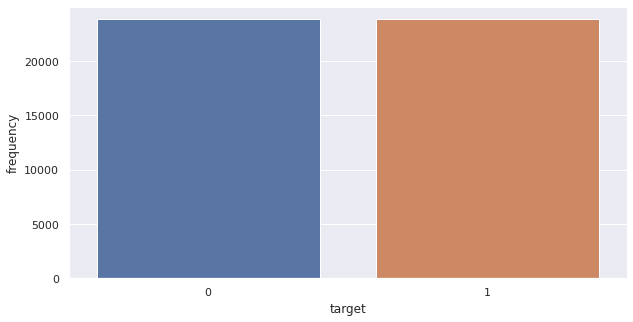

In [ ]:
#chcking for the distribution of target data after upsampling
fig, ax = plt.subplots(figsize = (10, 5))
sns.countplot('target', data = df_upsampled, order = df_upsampled['target'].value_counts().index, ax = ax)
ax.set(xlabel='target', ylabel='frequency')
plt.show()

> As we see now we have balanced data

In [ ]:
#converting the upsampled DataFrame into list again to be easy to use the preprocessing methods on it
training_set_T2 = df_upsampled.values.tolist()

In [ ]:
#splitting the train data into training and validation
training_set, validation_set = train_test_split(training_set_T2, test_size=0.15)
print(type(training_set))

<class 'list'>


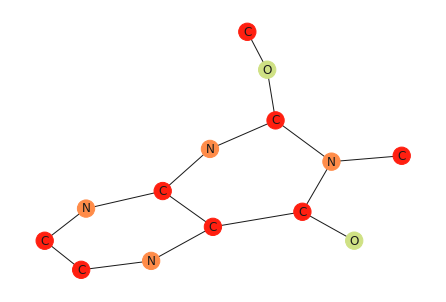

In [ ]:
#displaying one sample
plt.clf()
visualize(training_set_T2[5])

## Preprocessing

> Here I will apply the preprocessing methods

In [ ]:
#vocabulary size
max_vocab = 500
# maximum length of the tokenized vector
max_len = 100 

# build vocabulary from training set only for nodes characters
all_nodes = [s[0] for s in training_set_T2]

#training tokenizer
tokenizer = Tokenizer(num_words = max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [ ]:
# showing one batch:
for train_batch in gen_batch(training_set_T2, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)  
        print("Shape is "+str(np.shape(v)))
        pass
    print('label', train_batch[1])
    break

data
Shape is (192,)
edges
Shape is (117, 2)
node2grah
Shape is (192,)
label [1 0 1 1]


## Trial_2_1 (Demo)

> To understand the dimensions:
Let's assume the batch contains 10 samples of data.
The nodes are tokenized using 44 dimension array that is each sample node is of shape [44]
Thus 10 samples are of shape [440] after applying get_batch method
node2graph is also of shape [440] like [0,0,0,0,0,...,1,1,1,1,....2,2,2,....] each number is repeated 44 times [0,0,0,0,... 44 times]
Lets assume edges are of size [257,2]

> The GNN layer takes a GNNInput named tuple as input, which encapsulates initial node features, adjacency lists, and auxiliary information.


> in this trial i will use the demo to see the results and my expectation to get good results

### build the model architecture

In [ ]:
#Input layer for nodes (tokenized text data)
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch

#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
#embedding layer over data with each token embedded as a vector
embeded = Embedding(tokenizer.num_words, 80)(data)


# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))
num_graph = tf.reduce_max(node2graph)+1  

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer is 40
params["hidden_dim"] = 40
#gnn layer with defined hyperparameters
gnn_layer = GNN(params)  
#gnn output layer 
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input) 

print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

print('mean:', avg)

#final dense layer with sigmoid
pred = Dense(1, activation='sigmoid')(avg)
#output shape: [batch_size,1]
print('pred:', pred)

#Building The Model 
#inputs is dictionary of data, edges, node2graph
#output: prediction value from dense layer
model = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")


### display the model Summary and architecture

In [ ]:
#printing summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max (TFOpLambda  ()                  0           ['input_3[0][0]']                
 )                                                                                                
                                                                                                  
 embedding (Embedding)          (None, 80)           40000       ['input_1[0][0]']            

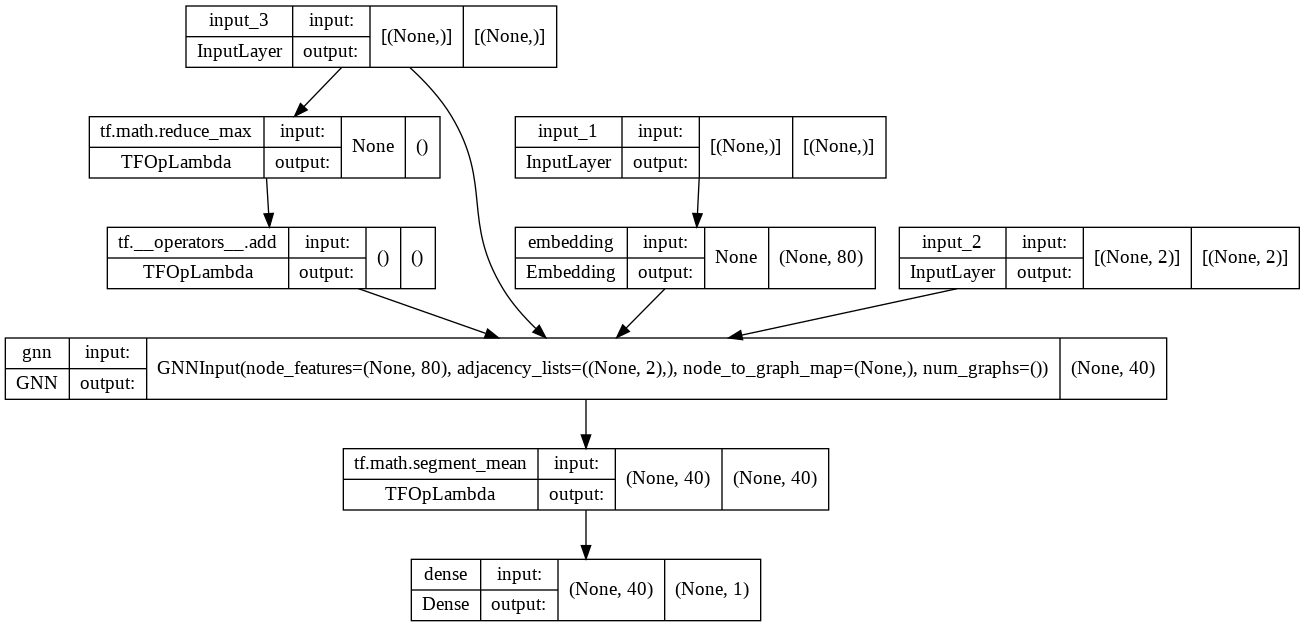

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

### compile and fit the model

in this trial i expect to get 
* auc score around 85% for training and get 
* 80% for validation 

because i make some improvement

In [ ]:
#I will create Adam Optimizer for training optimizer with this hyperparameters
ad = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)

In [ ]:
#compile the model by using my adam optimizer and BinaryCrossentropy loss
model.compile(
    optimizer = ad,
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
%%time
batch_size = 32
#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 10.7 µs


In [ ]:
#fit the models with 30 epoch and no early stopping
hist = model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1
)
print(hist)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 40), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a larg

1265/1265 [==============================] - 35s 22ms/step - loss: 0.6173 - auc: 0.7177 - val_loss: 0.5818 - val_auc: 0.7614
Epoch 2/30
1265/1265 [==============================] - 28s 22ms/step - loss: 0.5820 - auc: 0.7622 - val_loss: 0.5609 - val_auc: 0.7863
Epoch 3/30
1265/1265 [==============================] - 28s 22ms/step - loss: 0.5625 - auc: 0.7826 - val_loss: 0.5341 - val_auc: 0.8136
Epoch 4/30
1265/1265 [==============================] - 28s 22ms/step - loss: 0.5389 - auc: 0.8050 - val_loss: 0.5098 - val_auc: 0.8330
Epoch 5/30
1265/1265 [==============================] - 28s 22ms/step - loss: 0.5245 - auc: 0.8165 - val_loss: 0.5222 - val_auc: 0.8354
Epoch 6/30
1265/1265 [==============================] - 28s 22ms/step - loss: 0.5114 - auc: 0.8277 - val_loss: 0.5101 - val_auc: 0.8423
Epoch 7/30
1265/1265 [==============================] - 28s 22ms/step - loss: 0.4999 - auc: 0.8368 - val_loss: 0.4720 - val_auc: 0.8603
Epoch 8/30
1265/1265 [==============================] - 28s

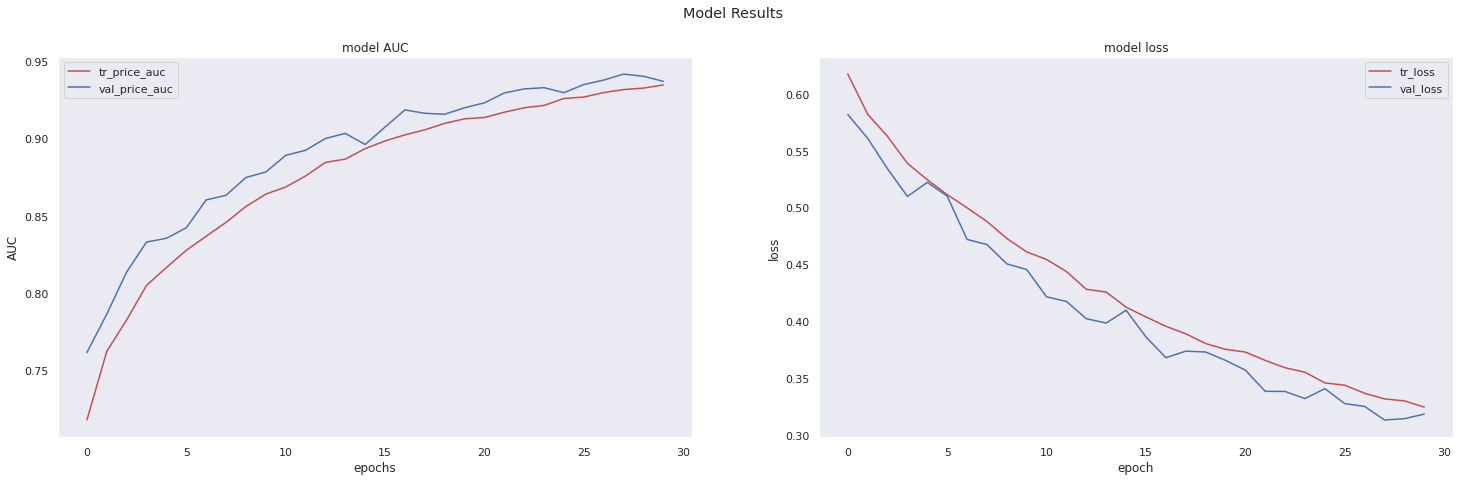

In [ ]:
#virtualize the results
results_virt(hist)

In [ ]:
#make a prediction by using the model
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [ ]:
#make a submission file to upload it on kaggle
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('Trial_2_1_Demo.csv')

#Kaggle==> 0.81906

> **As we see this model given me**
* around 93.5% training AUC score which is highest high than what i expected and very good
* around 93.7% validation AUC score better than what i expected and this is the highest score i get untill now
* around 82% score on kaggle which is good for this trial
* so this trial was good for the first trial with resampling i do which is not bad for the first trial but I will try anothr trial to see if the model will improve or not

> **my observation for this results**
* this model was good to reach this result as we see from the plots
* this model has hiegh AUC scores but also has high losses which it's not good but not bad
* this model has this results because this model has normal architecture
* so this model hasn't overfitting and underfitting

##Trial_2_2 (GGNN)

### build the model architecture

In [ ]:
#Input layer for nodes (tokenized text data)
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

#embedding layer over data with each token embedded as a vector   size vector eg. [440,75]
embeded = Embedding(tokenizer.num_words, 80)(data)

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))
num_graph = tf.reduce_max(node2graph)+1  

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
params["message_calculation_class"] = 'GGNN'
params["hidden_dim"] = 40
params["num_aggr_MLP_hidden_layers"] = 2
params["num_edge_MLP_hidden_layers"] = 2
params["num_heads"] = 8
params["num_layers"] = 4
params["dense_every_num_layers"] = 1
params["film_parameter_MLP_hidden_layers"] = 1


#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 

#gnn output layer
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(128,activation='relu')(avg)
fc2 = Dense(64,activation='relu')(fc1)

#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc2)
print('pred:', pred)

#Building The Model 
#inputs is dictionary of data, edges, node2graph
#output: prediction value from dense layer
model_2 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='gnn_6/StatefulPartitionedCall:0', description="created by layer 'gnn_6'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='tf.math.segment_mean_6/SegmentMean:0', description="created by layer 'tf.math.segment_mean_6'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_19/Sigmoid:0', description="created by layer 'dense_19'")


### display the model Summary and architecture

In [ ]:
#printing summary of the model
model_2.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_6 (TFOpLamb  ()                  0           ['input_21[0][0]']               
 da)                                                                                              
                                                                                                  
 embedding_6 (Embedding)        (None, 80)           40000       ['input_19[0][0]']         

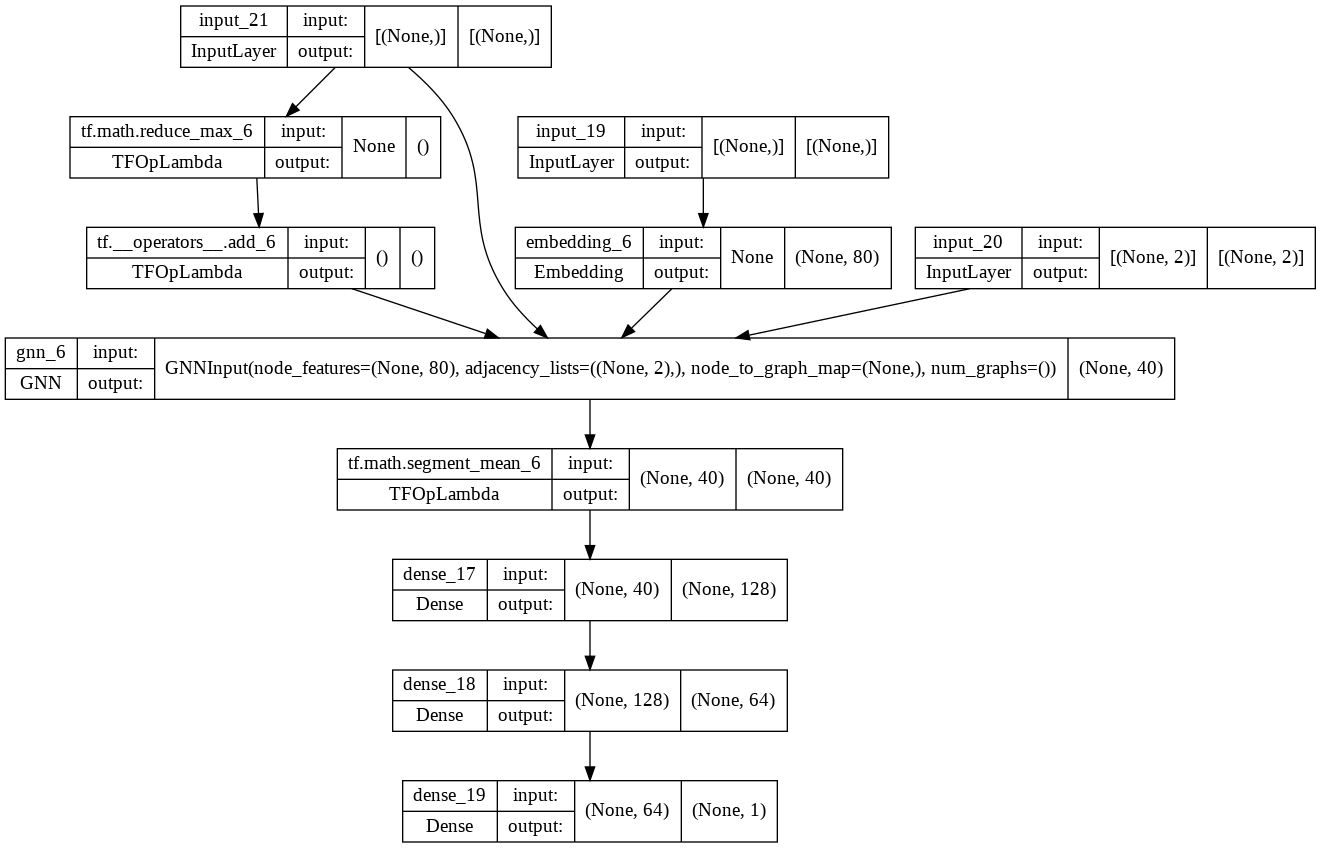

In [ ]:
tf.keras.utils.plot_model(model_2, show_shapes=True)

### compile and fit the model

in this trial i expect to get 
* auc score around 95% for training and get 
* 90% for validation 

because i make some improvement

In [ ]:
#compile the model by using my adam optimizer and BinaryCrossentropy loss
model_2.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 64

#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)

#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)



In [ ]:
#fit the models with 30 epoch and using early stopping to avoid overfitting
hist_2 = model_2.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
   callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3),
    verbose=1
)
print(hist_2)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape:0", shape=(None, 40), dtype=float32), dense_shape=Tensor("gradients/ggnn_3/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape:0", shape=(None, 40), dtype=float32), dense_shape=Tensor("gradients/ggnn_2/embedding_lookup_grad/Cast:0", s

1265/1265 [==============================] - 49s 36ms/step - loss: 0.6294 - auc: 0.6946 - val_loss: 0.5704 - val_auc: 0.7707
Epoch 2/30
1265/1265 [==============================] - 44s 35ms/step - loss: 0.5499 - auc: 0.7936 - val_loss: 0.5408 - val_auc: 0.8110
Epoch 3/30
1265/1265 [==============================] - 41s 32ms/step - loss: 0.5150 - auc: 0.8258 - val_loss: 0.4746 - val_auc: 0.8588
Epoch 4/30
1265/1265 [==============================] - 41s 33ms/step - loss: 0.4850 - auc: 0.8485 - val_loss: 0.4639 - val_auc: 0.8698
Epoch 5/30
1265/1265 [==============================] - 41s 33ms/step - loss: 0.4583 - auc: 0.8665 - val_loss: 0.4409 - val_auc: 0.8801
Epoch 6/30
1265/1265 [==============================] - 40s 32ms/step - loss: 0.4330 - auc: 0.8819 - val_loss: 0.4075 - val_auc: 0.8963
Epoch 7/30
1265/1265 [==============================] - 41s 32ms/step - loss: 0.4069 - auc: 0.8964 - val_loss: 0.3693 - val_auc: 0.9162
Epoch 8/30
1265/1265 [==============================] - 43s

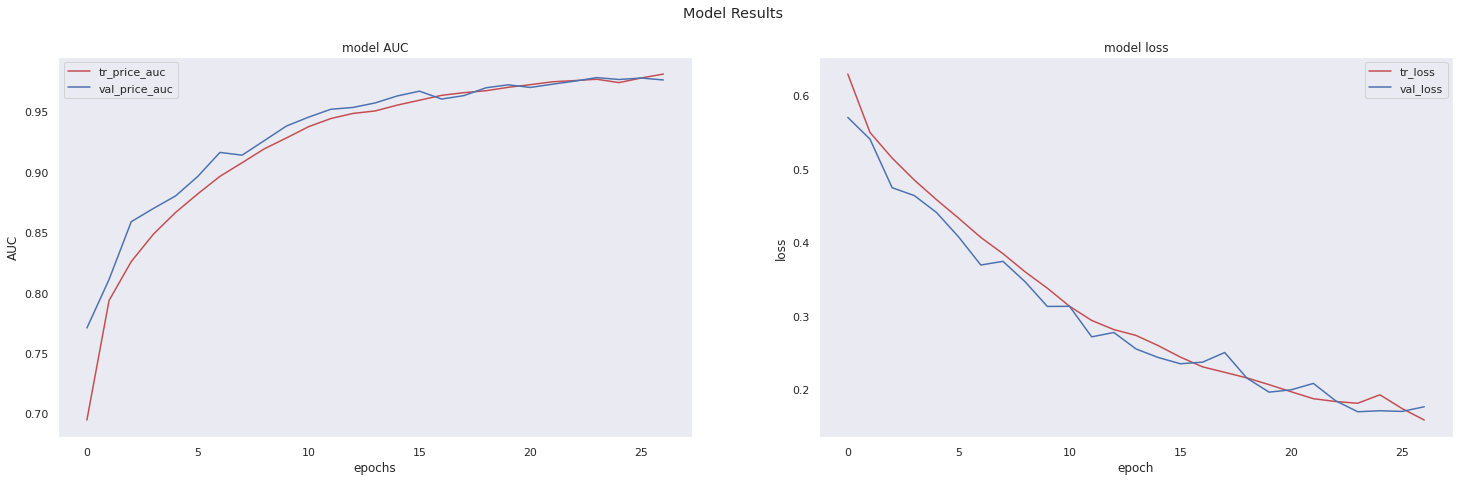

In [ ]:
#virtualize the results
results_virt(hist_2)

In [ ]:
#make a prediction by using the model
y_pred_2 = model_2.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred_2 = np.reshape(y_pred_2, -1)

In [ ]:
#make a submission file to upload it on kaggle
submission = pd.DataFrame({'label':y_pred_2})
submission.index.name = 'id'
submission.to_csv('trial_2_2_1428_GGNN.csv')

#Kaggle==> 0.87255

> **As we see this model given me**
* around 98% training AUC score highest than what i expected and so good
* around 97.6% validation AUC score better than what i expected so it's good and this is the best one until now
* 87.3% score on kaggle which is good
* so this trial was the best trial but I will try anothr trial to see if the model will improve or not

    **[the highest score i get so this model is the best model until now]**
> **my observation for this results**
* this model was good to reach this result as we see from the plots
* this model is very good has high scores and has low losses so ***this model is the best model***
* this model hadn't overfitting or underfitting

##Trial_2_3 (RGCN)

> in this trial i will use the RGCN model with some dense layers to see if there is any improve or not

### build the model architecture

In [ ]:
#Input layer for nodes (tokenized text data)
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

#embedding layer over data with each token embedded as a vector   size vector eg. [440,75]
embeded = Embedding(tokenizer.num_words, 70)(data)

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))
num_graph = tf.reduce_max(node2graph)+1  

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer

params["message_calculation_class"] = 'RGCN'
params["hidden_dim"] = 40
params["num_aggr_MLP_hidden_layers"] = 2
params["num_edge_MLP_hidden_layers"] = 2
params["num_heads"] = 8
params["num_layers"] = 4
params["dense_every_num_layers"] = 1
params["film_parameter_MLP_hidden_layers"] = 1

#params["num_edge_MLP_hidden_layers"] = 16

#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 

#gnn output layer
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(256,activation='relu')(avg)
fc2 = Dense(128,activation='relu')(fc1)
fc3 = Dense(64,activation='relu')(fc2)
# d1 = Dropout(0.2)(fc2)

#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc3)
print('pred:', pred)

#Building The Model 
#inputs is dictionary of data, edges, node2graph
#output: prediction value from dense layer
model_3 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='gnn_7/StatefulPartitionedCall:0', description="created by layer 'gnn_7'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='tf.math.segment_mean_7/SegmentMean:0', description="created by layer 'tf.math.segment_mean_7'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_23/Sigmoid:0', description="created by layer 'dense_23'")


### display the model Summary and architecture

In [ ]:
#printing summary of the model
model_3.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_7 (TFOpLamb  ()                  0           ['input_24[0][0]']               
 da)                                                                                              
                                                                                                  
 embedding_7 (Embedding)        (None, 70)           35000       ['input_22[0][0]']         

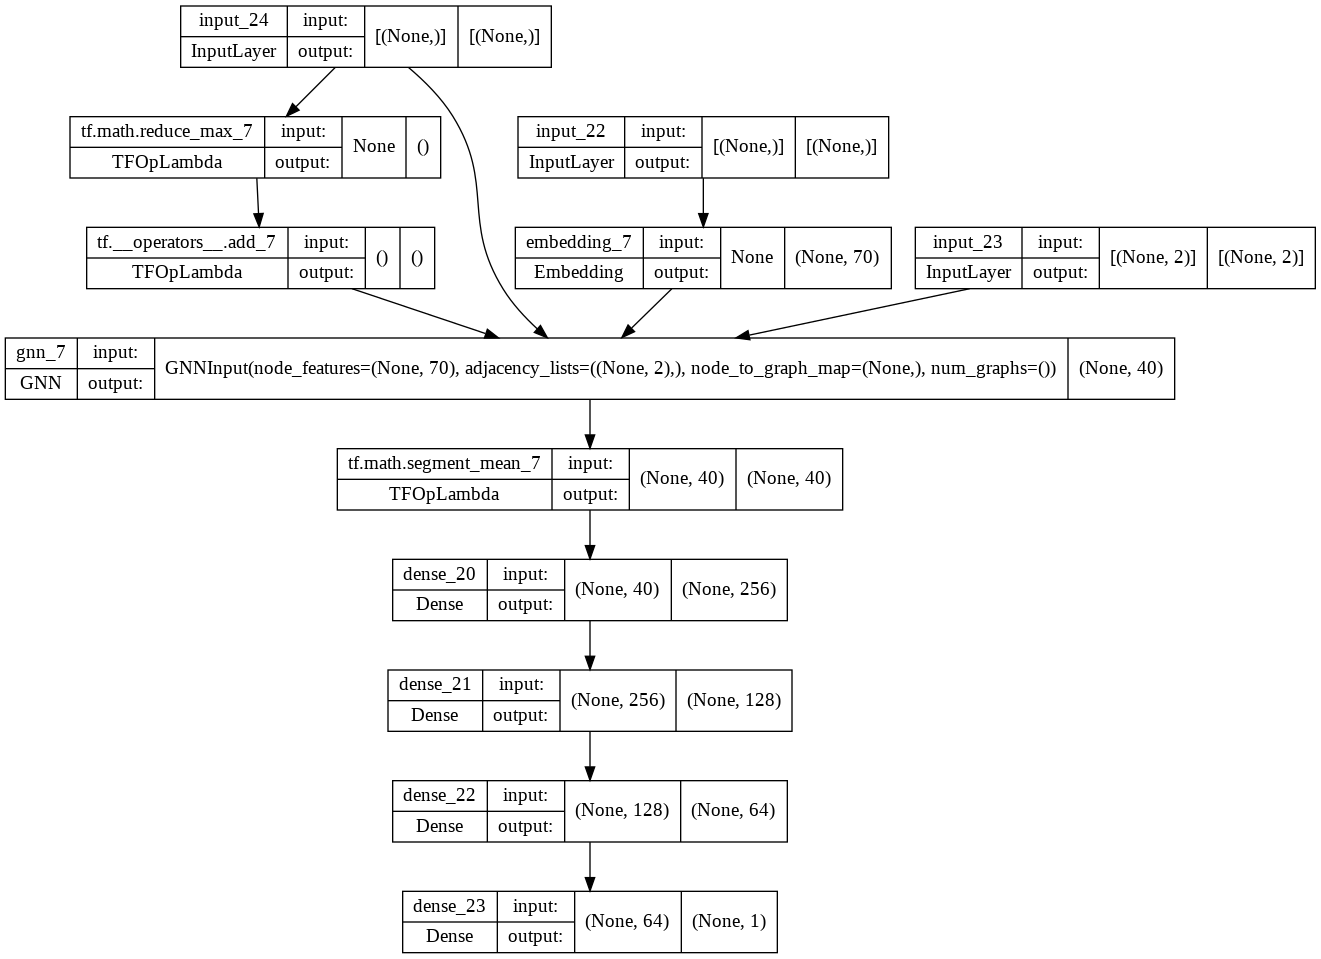

In [ ]:
tf.keras.utils.plot_model(model_3, show_shapes=True)

### compile and fit the model

in this trial i expect to get 
* auc score around 95% for training and get 
* 92% for validation 

In [ ]:
#compile the model by using adam optimizer and BinaryCrossentropy loss
model_3.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 64

#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)

#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)



In [ ]:
#fit the models with 30 epoch and using early stopping to avoid overfitting
hist_3 = model_3.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
  #  callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3),
    verbose=1
)
print(hist_3)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 40), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape:0", shape=(None, 40), dtype=float32), dense_shape=Tensor("gradients/rgcn_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor

633/633 [==============================] - 21s 27ms/step - loss: 0.6259 - auc: 0.7002 - val_loss: 0.6188 - val_auc: 0.7364
Epoch 2/30
633/633 [==============================] - 19s 30ms/step - loss: 0.5867 - auc: 0.7537 - val_loss: 0.5770 - val_auc: 0.7724
Epoch 3/30
633/633 [==============================] - 18s 28ms/step - loss: 0.5774 - auc: 0.7652 - val_loss: 0.5569 - val_auc: 0.7880
Epoch 4/30
633/633 [==============================] - 18s 28ms/step - loss: 0.5632 - auc: 0.7809 - val_loss: 0.5561 - val_auc: 0.7916
Epoch 5/30
633/633 [==============================] - 18s 29ms/step - loss: 0.5412 - auc: 0.8028 - val_loss: 0.5388 - val_auc: 0.8183
Epoch 6/30
633/633 [==============================] - 18s 28ms/step - loss: 0.5174 - auc: 0.8226 - val_loss: 0.4822 - val_auc: 0.8500
Epoch 7/30
633/633 [==============================] - 18s 28ms/step - loss: 0.5029 - auc: 0.8342 - val_loss: 0.5012 - val_auc: 0.8496
Epoch 8/30
633/633 [==============================] - 18s 29ms/step - los

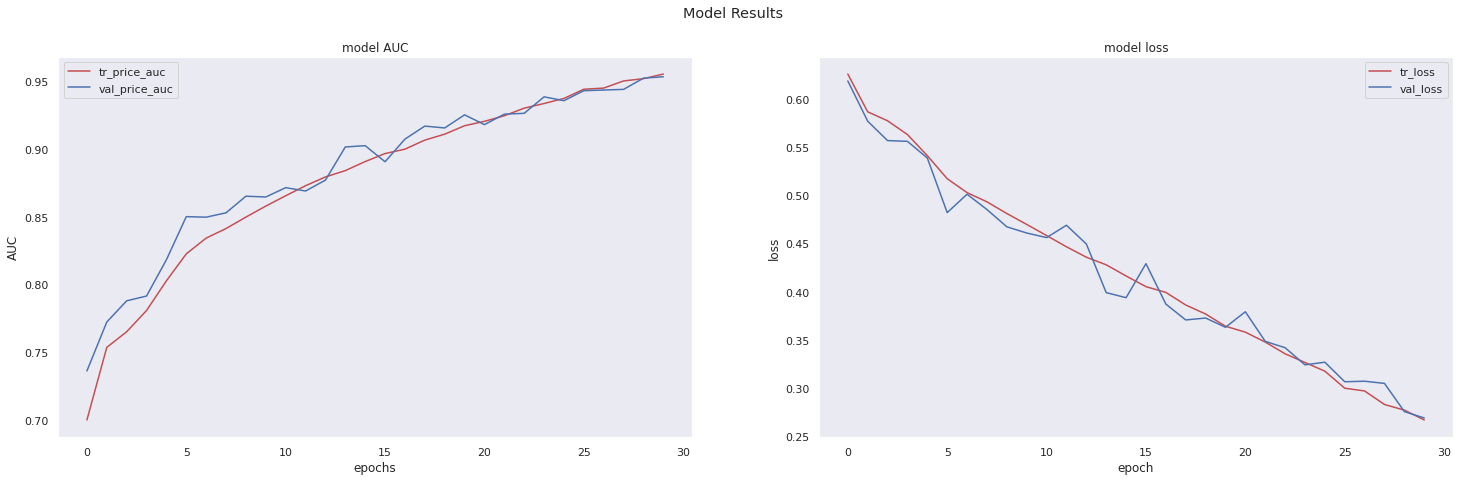

In [ ]:
#virtualize the results
results_virt(hist_3)

In [ ]:
#make a prediction by using the model
y_pred_3 = model_3.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred_3 = np.reshape(y_pred_3, -1)

In [ ]:
#make a submission file to upload it on kaggle
submission = pd.DataFrame({'label':y_pred_3})
submission.index.name = 'id'
submission.to_csv('trial_2_3_RGCN.csv')

#Kaggle => 0.82402

> **As we see this model given me**
* around 95.5% training AUC score look like what i expected
* around 95.3% validation AUC score more than what i expected
* 82.4% score on kaggle which is good
* so this trial was good but not has any improve so I will try anothr trial to see if the model will improve or not

> **my observation for this results**
* this model has a nice results but this model not the best model until it has a good results but need to some improve to be very good model
* so this model hadn't overfitting or underfitting which is good

##Trial_2_4 (RGAT)

### build the model architecture

In [ ]:
#Input layer for nodes (tokenized text data)
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

#embedding layer over data with each token embedded as a vector   size vector eg. [440,75]
embeded = Embedding(tokenizer.num_words, 70)(data)

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))
num_graph = tf.reduce_max(node2graph)+1  

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
params["message_calculation_class"] = 'RGAT'
params["hidden_dim"] = 40
params["num_aggr_MLP_hidden_layers"] = 2
params["num_edge_MLP_hidden_layers"] = 2
params["num_heads"] = 8
params["num_layers"] = 4
params["dense_every_num_layers"] = 1
params["film_parameter_MLP_hidden_layers"] = 1



#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 

#gnn output layer
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(64,activation='relu')(avg)
fc2 = Dense(32,activation='relu')(fc1)
# d1 = Dropout(0.2)(fc2)

#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc2)
print('pred:', pred)

#Building The Model 
#inputs is dictionary of data, edges, node2graph
#output: prediction value from dense layer
model_4 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='gnn_8/StatefulPartitionedCall:0', description="created by layer 'gnn_8'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='tf.math.segment_mean_8/SegmentMean:0', description="created by layer 'tf.math.segment_mean_8'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_26/Sigmoid:0', description="created by layer 'dense_26'")


### display the model Summary and architecture

In [ ]:
#printing summary of the model
model_4.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_25 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_8 (TFOpLamb  ()                  0           ['input_27[0][0]']               
 da)                                                                                              
                                                                                                  
 embedding_8 (Embedding)        (None, 70)           35000       ['input_25[0][0]']         

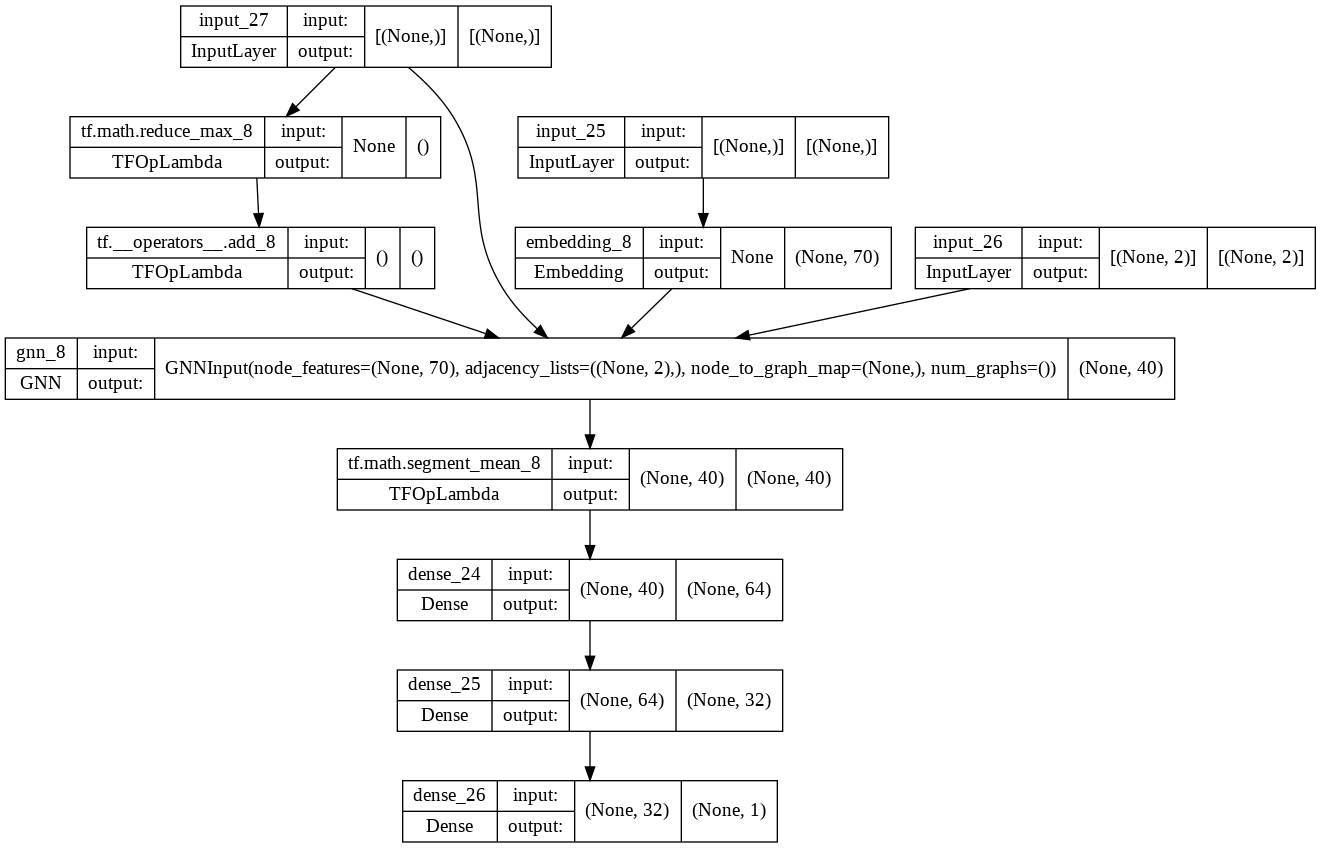

In [ ]:
tf.keras.utils.plot_model(model_4, show_shapes=True)

### compile and fit the model

in this trial i expect to get 
* auc score around 95% for training and get 
* 95% for validation 

because i make some improvement

In [ ]:
#compile the model by using adam optimizer and BinaryCrossentropy loss
model_4.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 64

#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)

#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)



In [ ]:
#fit the models with 30 epoch and using early stopping to avoid overfitting
hist_4 = model_4.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
  #  callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3),
    # verbose=1
)
print(hist_4)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amo

633/633 [==============================] - 53s 68ms/step - loss: 0.6192 - auc: 0.7111 - val_loss: 0.5889 - val_auc: 0.7546
Epoch 2/30
633/633 [==============================] - 40s 63ms/step - loss: 0.5863 - auc: 0.7530 - val_loss: 0.5729 - val_auc: 0.7757
Epoch 3/30
633/633 [==============================] - 40s 63ms/step - loss: 0.5667 - auc: 0.7764 - val_loss: 0.5499 - val_auc: 0.8061
Epoch 4/30
633/633 [==============================] - 40s 63ms/step - loss: 0.5424 - auc: 0.8010 - val_loss: 0.5136 - val_auc: 0.8281
Epoch 5/30
633/633 [==============================] - 40s 63ms/step - loss: 0.5218 - auc: 0.8190 - val_loss: 0.5113 - val_auc: 0.8332
Epoch 6/30
633/633 [==============================] - 41s 65ms/step - loss: 0.5044 - auc: 0.8330 - val_loss: 0.4948 - val_auc: 0.8517
Epoch 7/30
633/633 [==============================] - 42s 67ms/step - loss: 0.4857 - auc: 0.8470 - val_loss: 0.4621 - val_auc: 0.8649
Epoch 8/30
633/633 [==============================] - 41s 65ms/step - los

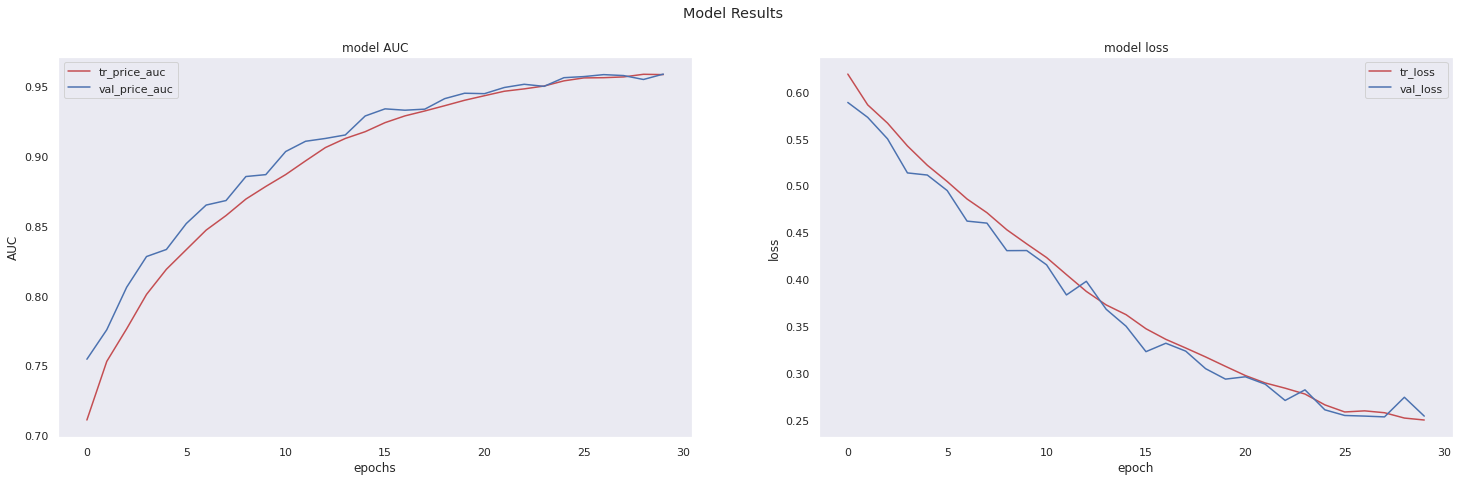

In [ ]:
#virtualize the results
results_virt(hist_4)

In [ ]:
#make a prediction by using the model
y_pred_4 = model_4.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred_4 = np.reshape(y_pred_4, -1)

In [ ]:
#make a submission file to upload it on kaggle
submission = pd.DataFrame({'label':y_pred_4})
submission.index.name = 'id'
submission.to_csv('trial_2_4_RGAT.csv')

#kaggle ==> 0.83512

> **As we see this model given me**
* around 96% training AUC score so close to my expectation
* around 96% validation AUC score so close to my expectation
* 83.5% score on kaggle which is good
* So we see that this trial is a little better than the previous one
* so this trial was good but not the best one so I will try anothr trial to see if the model will improve or not

> **my observation for this results**
* this model has a nice results but this model not the best model until it has a good results but need to some improve to be very good model
* so this model hadn't overfitting or underfitting which is good

##Trial_2_5 (RGIN)

> in this trial i will use the RGIN model with some dense layers to see if there is any improve or not

### build the model architecture

In [ ]:
#Input layer for nodes (tokenized text data)
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

#embedding layer over data with each token embedded as a vector   size vector eg. [440,75]
embeded = Embedding(tokenizer.num_words, 80)(data)

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))
num_graph = tf.reduce_max(node2graph)+1  

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer

params["message_calculation_class"] = 'RGIN'
params["hidden_dim"] = 40
params["num_aggr_MLP_hidden_layers"] = 2
params["num_edge_MLP_hidden_layers"] = 2
params["num_heads"] = 8
params["num_layers"] = 4
params["dense_every_num_layers"] = 1
params["film_parameter_MLP_hidden_layers"] = 1



#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 

#gnn output layer
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(64,activation='relu')(avg)
fc2 = Dense(32,activation='relu')(fc1)
# d1 = Dropout(0.2)(fc2)

#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc2)
print('pred:', pred)

#Building The Model 
#inputs is dictionary of data, edges, node2graph
#output: prediction value from dense layer
model_5 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='gnn_10/StatefulPartitionedCall:0', description="created by layer 'gnn_10'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='tf.math.segment_mean_10/SegmentMean:0', description="created by layer 'tf.math.segment_mean_10'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_32/Sigmoid:0', description="created by layer 'dense_32'")


### display the model Summary and architecture

In [ ]:
#printing summary of the model
model_5.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_31 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_10 (TFOpLam  ()                  0           ['input_33[0][0]']               
 bda)                                                                                             
                                                                                                  
 embedding_10 (Embedding)       (None, 80)           40000       ['input_31[0][0]']        

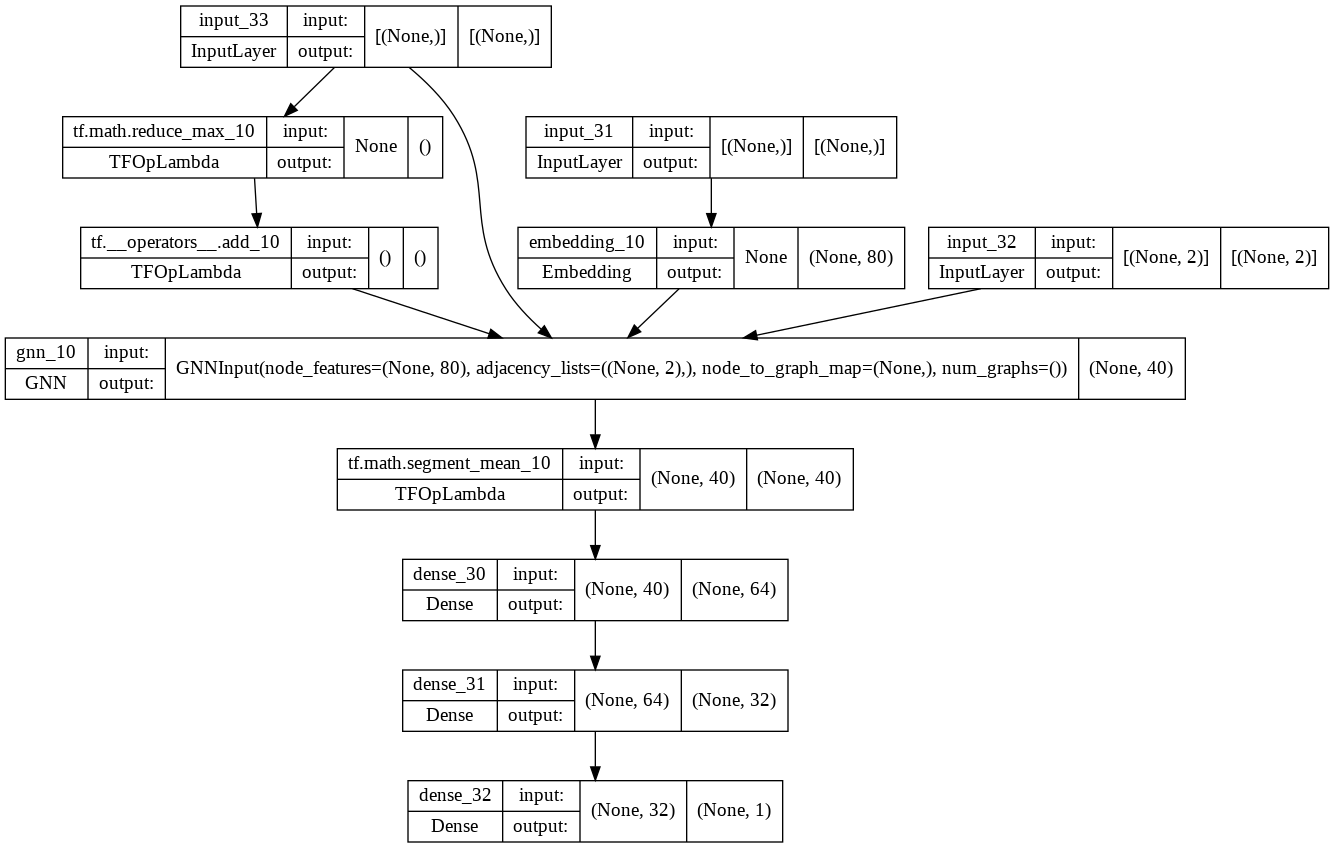

In [ ]:
tf.keras.utils.plot_model(model_5, show_shapes=True)

### compile and fit the model

in this trial i expect to get 
* auc score around 90% for training and get 
* 85% for validation 

because this model was not very good in the previous trial 

In [ ]:
#compile the model by using adam optimizer and BinaryCrossentropy loss
model_5.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 64

#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)

#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)



In [ ]:
#fit the models with 30 epoch and using early stopping to avoid overfitting
hist_5 = model_5.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
  #  callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3),
    # verbose=1
)
print(hist_5)

Epoch 1/30
633/633 [==============================] - 32s 50ms/step - loss: 0.6054 - auc: 0.7284 - val_loss: 0.5888 - val_auc: 0.7535
Epoch 2/30
633/633 [==============================] - 22s 34ms/step - loss: 0.5973 - auc: 0.7396 - val_loss: 0.5866 - val_auc: 0.7539
Epoch 3/30
633/633 [==============================] - 21s 32ms/step - loss: 0.5926 - auc: 0.7444 - val_loss: 0.5828 - val_auc: 0.7538
Epoch 4/30
633/633 [==============================] - 20s 32ms/step - loss: 0.5830 - auc: 0.7556 - val_loss: 0.5793 - val_auc: 0.7626
Epoch 5/30
633/633 [==============================] - 20s 32ms/step - loss: 0.5820 - auc: 0.7578 - val_loss: 0.5695 - val_auc: 0.7725
Epoch 6/30
633/633 [==============================] - 21s 33ms/step - loss: 0.5834 - auc: 0.7575 - val_loss: 0.5828 - val_auc: 0.7690
Epoch 7/30
633/633 [==============================] - 21s 34ms/step - loss: 0.5666 - auc: 0.7772 - val_loss: 0.5414 - val_auc: 0.8043
Epoch 8/30
633/633 [==============================] - 21s 34ms

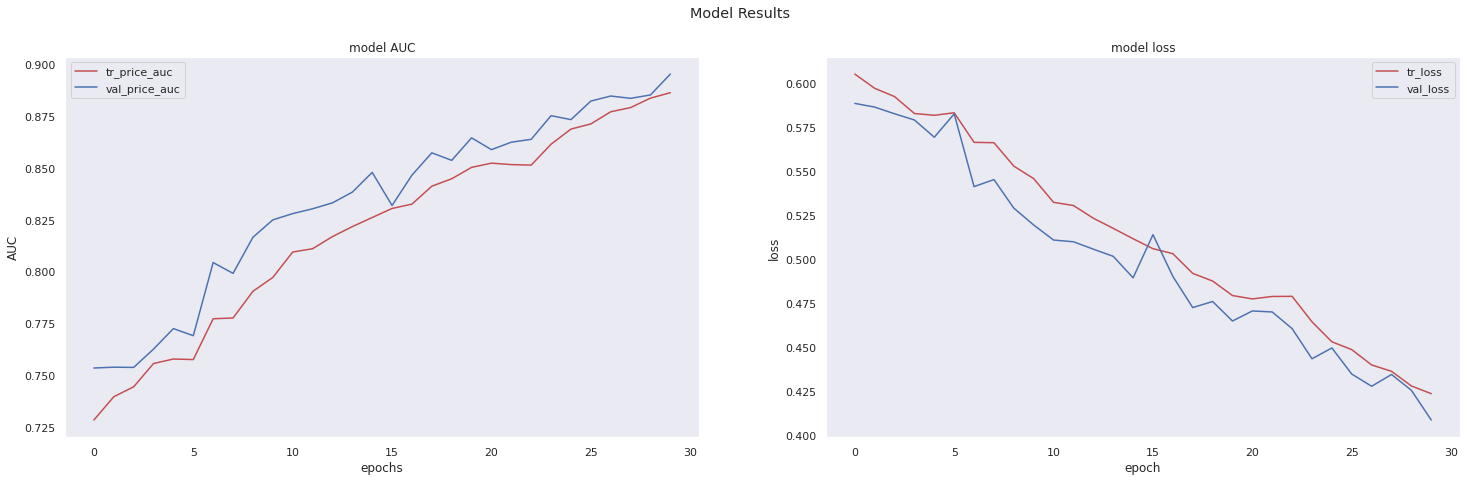

In [ ]:
#virtualize the results
results_virt(hist_5)

In [ ]:
#make a prediction by using the model
y_pred_5 = model_5.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred_5 = np.reshape(y_pred_5, -1)

In [ ]:
#make a submission file to upload it on kaggle
submission = pd.DataFrame({'label':y_pred_5})
submission.index.name = 'id'
submission.to_csv('trial_2_5_RGIN.csv')

#kaggle ==> 0.81427

> **As we see this model given me**
* around 89% training AUC score so close to my expectation
* around 88.5% validation AUC score more than my expectation
* 81.5% score on kaggle which is not good
* So we see that this trial is a bad trial in this Trials after i made a resampling 
* so I will try anothr trial to see if the model will improve or not

> **my observation for this results**
*This model has fairly good results but not a good one that I have built but need to some improve to be very good model
* this model has very bad loss score which has losses around 42% and 40% which so bad

##Trial_2_6 (GNN-Edge-ML)

### build the model architecture

In [ ]:
#Input layer for nodes (tokenized text data)
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

#embedding layer over data with each token embedded as a vector   size vector eg. [440,75]
embeded = Embedding(tokenizer.num_words, 80)(data)

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))
num_graph = tf.reduce_max(node2graph)+1  

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
params["message_calculation_class"] = 'gnn_edge_mlp'
params["hidden_dim"] = 40
params["num_aggr_MLP_hidden_layers"] = 2
params["num_edge_MLP_hidden_layers"] = 2
params["num_heads"] = 8
params["num_layers"] = 4
params["dense_every_num_layers"] = 1
params["film_parameter_MLP_hidden_layers"] = 1



#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 

#gnn output layer
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(64,activation='relu')(avg)
fc2 = Dense(32,activation='relu')(fc1)
# d1 = Dropout(0.2)(fc2)

#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc2)
print('pred:', pred)

#Building The Model 
#inputs is dictionary of data, edges, node2graph
#output: prediction value from dense layer
model_6 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='gnn_11/StatefulPartitionedCall:0', description="created by layer 'gnn_11'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='tf.math.segment_mean_11/SegmentMean:0', description="created by layer 'tf.math.segment_mean_11'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_35/Sigmoid:0', description="created by layer 'dense_35'")


### display the model Summary and architecture

In [ ]:
#printing summary of the model
model_6.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_34 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_11 (TFOpLam  ()                  0           ['input_36[0][0]']               
 bda)                                                                                             
                                                                                                  
 embedding_11 (Embedding)       (None, 80)           40000       ['input_34[0][0]']        

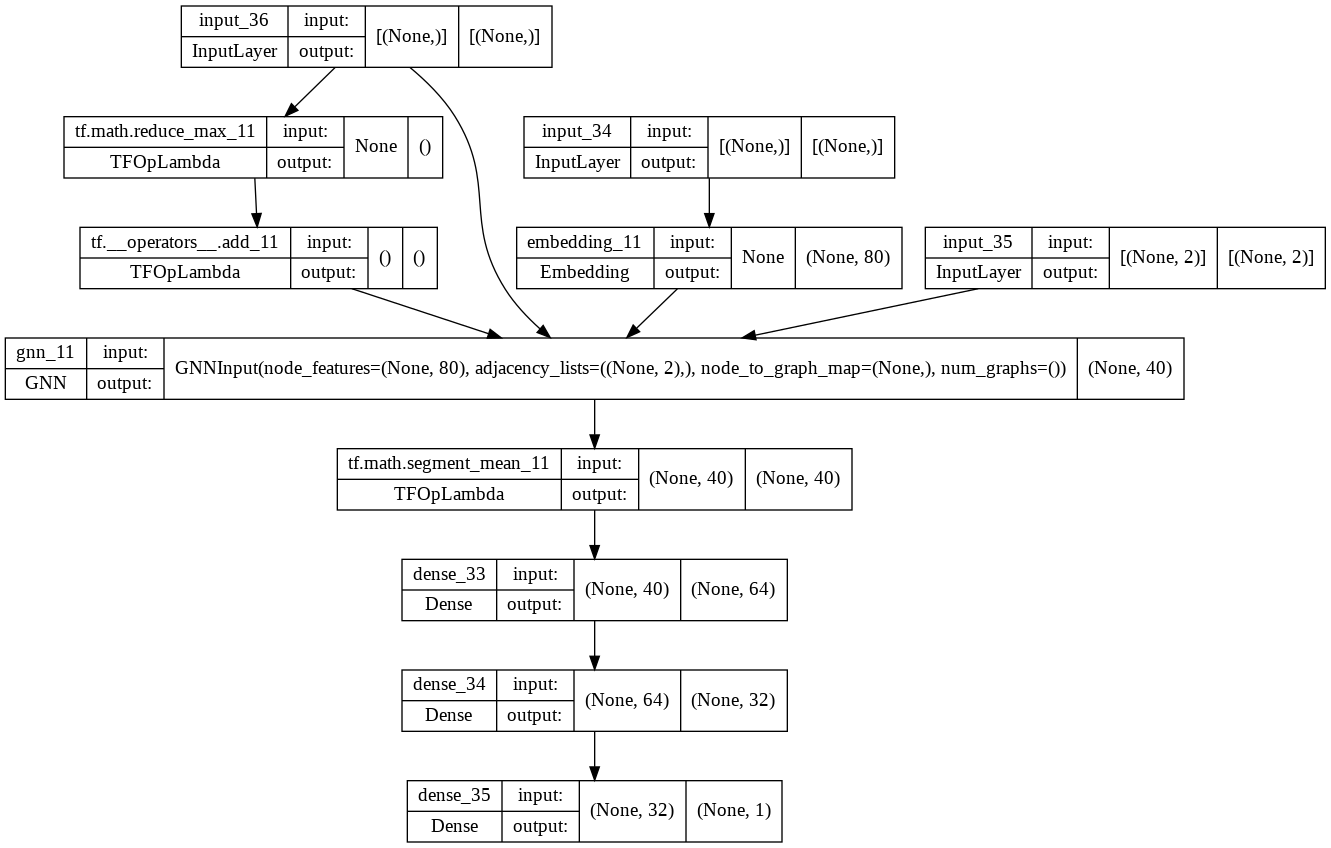

In [ ]:
tf.keras.utils.plot_model(model_6, show_shapes=True)

### compile and fit the model

in this trial i expect to get 
* auc score around 94% for training and get 
* 90% for validation 

because this model was not the best one in the first trial

In [ ]:
#compile the model by using adam optimizer and BinaryCrossentropy loss
model_6.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 64

#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)

#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)



In [ ]:
#fit the models with 30 epoch and using early stopping to avoid overfitting
hist_6 = model_6.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
  #  callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3),
    # verbose=1
)
print(hist_6)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 40), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/gnn__edge_mlp_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/gnn__edge_mlp_2/embedding_lookup_grad/Reshape:0", shape=(None, 40), dtype=float32), dense_shape=Tensor("gradients/gnn__edge_mlp_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype

633/633 [==============================] - 23s 31ms/step - loss: 0.6237 - auc: 0.7062 - val_loss: 0.5882 - val_auc: 0.7499
Epoch 2/30
633/633 [==============================] - 19s 30ms/step - loss: 0.5861 - auc: 0.7532 - val_loss: 0.5971 - val_auc: 0.7710
Epoch 3/30
633/633 [==============================] - 19s 30ms/step - loss: 0.5751 - auc: 0.7670 - val_loss: 0.5496 - val_auc: 0.7941
Epoch 4/30
633/633 [==============================] - 20s 31ms/step - loss: 0.5593 - auc: 0.7844 - val_loss: 0.5349 - val_auc: 0.8121
Epoch 5/30
633/633 [==============================] - 19s 31ms/step - loss: 0.5444 - auc: 0.7994 - val_loss: 0.5059 - val_auc: 0.8354
Epoch 6/30
633/633 [==============================] - 22s 34ms/step - loss: 0.5341 - auc: 0.8094 - val_loss: 0.5291 - val_auc: 0.8185
Epoch 7/30
633/633 [==============================] - 21s 34ms/step - loss: 0.5201 - auc: 0.8217 - val_loss: 0.4988 - val_auc: 0.8445
Epoch 8/30
633/633 [==============================] - 23s 37ms/step - los

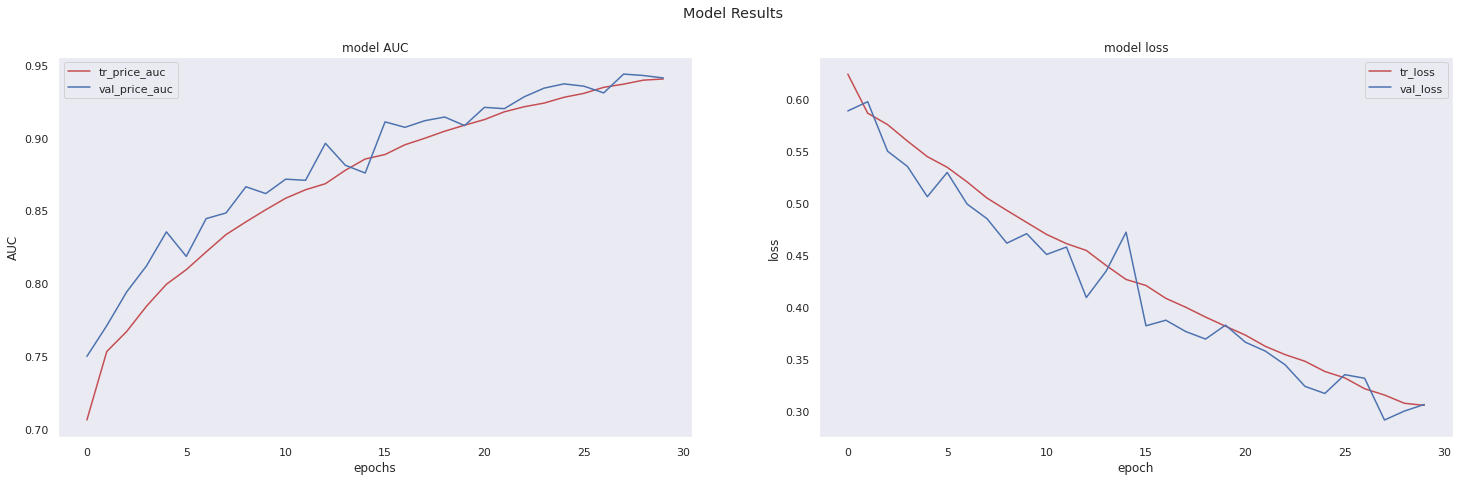

In [ ]:
#virtualize the results
results_virt(hist_6)

In [ ]:
#make a prediction by using the model
y_pred_6 = model_6.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred_6 = np.reshape(y_pred_6, -1)

In [ ]:
#make a submission file to upload it on kaggle
submission = pd.DataFrame({'label':y_pred_6})
submission.index.name = 'id'
submission.to_csv('trial_2_6_GNN-Edge-ML.csv')

#kaggle ==> 0.83209

> **As we see this model given me**
* around 94% training AUC score look like to my expectation
* around 94% validation AUC score more than my expectation
* 83.2% score on kaggle which is not the best one but it's good
* So we see that this trial is a good trial and this trial is better than the previous one which is good
* so I will try anothr trial to see if the model will improve or not

> **my observation for this results**
*This model has fairly good results but not a good one that I have built but need to some improve to be very good model
* this model has little high losses scores which has losses around 30% and 30% which it's not good

##Trial_2_7 (GNN-FiLM)

### build the model architecture

In [ ]:
#Input layer for nodes (tokenized text data)
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

#embedding layer over data with each token embedded as a vector   size vector eg. [440,75]
embeded = Embedding(tokenizer.num_words, 80)(data)

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))
num_graph = tf.reduce_max(node2graph)+1  

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer

params["message_calculation_class"] = 'GNN_FiLM'
params["hidden_dim"] = 40
params["num_aggr_MLP_hidden_layers"] = 2
params["num_edge_MLP_hidden_layers"] = 2
params["num_heads"] = 8
params["num_layers"] = 4
params["dense_every_num_layers"] = 1
params["film_parameter_MLP_hidden_layers"] = 1



#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 

#gnn output layer
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(64,activation='relu')(avg)
fc2 = Dense(32,activation='relu')(fc1)
# d1 = Dropout(0.2)(fc2)

#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc2)
print('pred:', pred)

#Building The Model 
#inputs is dictionary of data, edges, node2graph
#output: prediction value from dense layer
model_7 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='gnn_12/StatefulPartitionedCall:0', description="created by layer 'gnn_12'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='tf.math.segment_mean_12/SegmentMean:0', description="created by layer 'tf.math.segment_mean_12'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_38/Sigmoid:0', description="created by layer 'dense_38'")


### display the model Summary and architecture

In [ ]:
#printing summary of the model
model_7.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_37 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_12 (TFOpLam  ()                  0           ['input_39[0][0]']               
 bda)                                                                                             
                                                                                                  
 embedding_12 (Embedding)       (None, 80)           40000       ['input_37[0][0]']        

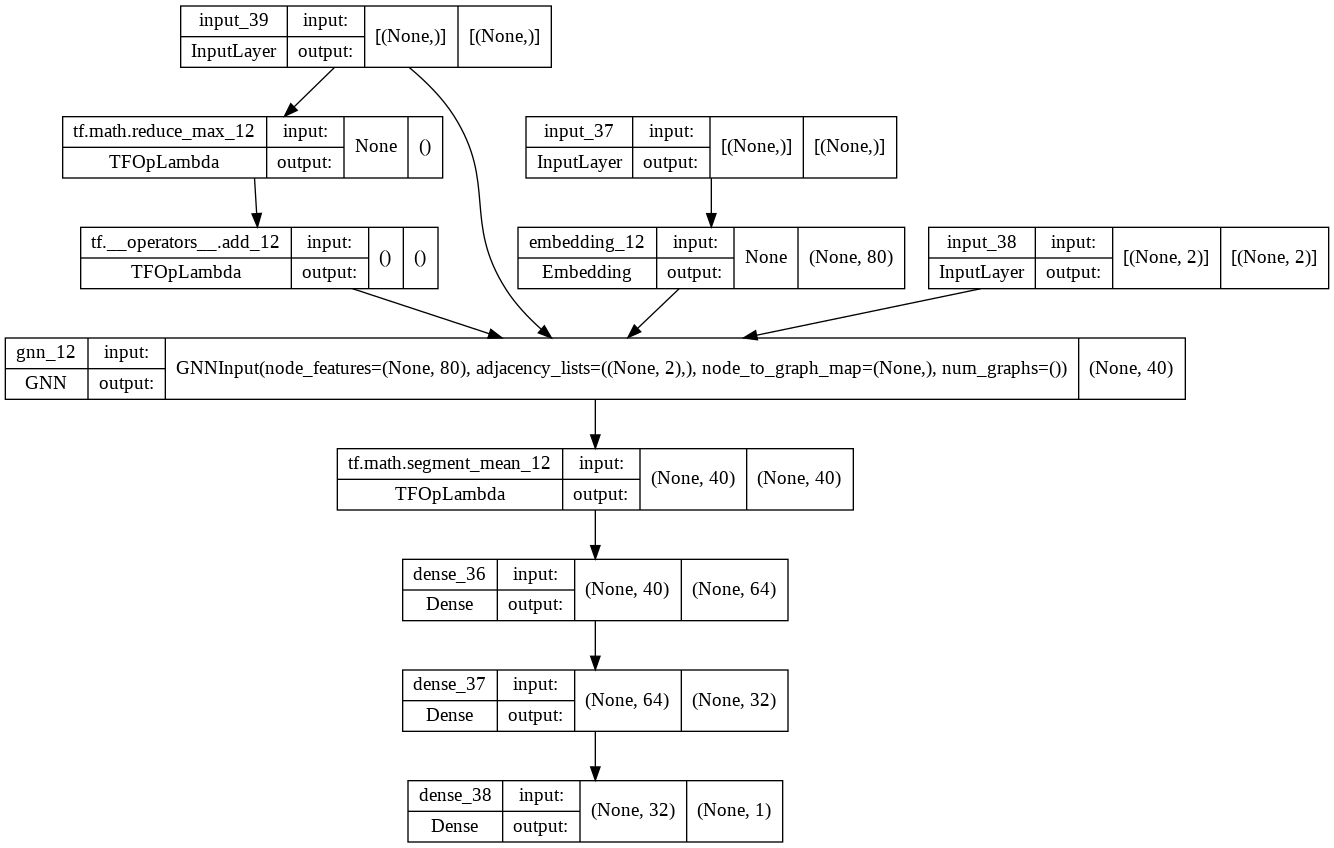

In [ ]:
tf.keras.utils.plot_model(model_7, show_shapes=True)

### compile and fit the model

in this trial i expect to get 
* auc score around 97% for training and get 
* 95% for validation 

because this model was good before resampling so i expect to give me good results

In [ ]:
#compile the model by using adam optimizer and BinaryCrossentropy loss
model_7.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 64

#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)

#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)



In [ ]:
#fit the models with 30 epoch and using early stopping to avoid overfitting
hist_7 = model_7.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
  #  callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3),
    # verbose=1
)
print(hist_7)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 40), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/concat_3:0", shape=(None,), dtype=int32), values=Tensor("gradients/concat_2:0", shape=(None, 40), dtype=float32), dense_shape=Tensor("gradients/gnn__fi_lm_2/embedding_lookup_1_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount

633/633 [==============================] - 70s 36ms/step - loss: 0.6143 - auc: 0.7181 - val_loss: 0.5474 - val_auc: 0.7962
Epoch 2/30
633/633 [==============================] - 22s 34ms/step - loss: 0.5476 - auc: 0.7976 - val_loss: 0.5164 - val_auc: 0.8238
Epoch 3/30
633/633 [==============================] - 22s 34ms/step - loss: 0.5170 - auc: 0.8233 - val_loss: 0.4905 - val_auc: 0.8471
Epoch 4/30
633/633 [==============================] - 22s 34ms/step - loss: 0.4946 - auc: 0.8411 - val_loss: 0.4691 - val_auc: 0.8608
Epoch 5/30
633/633 [==============================] - 22s 34ms/step - loss: 0.4737 - auc: 0.8554 - val_loss: 0.4658 - val_auc: 0.8609
Epoch 6/30
633/633 [==============================] - 21s 34ms/step - loss: 0.4515 - auc: 0.8704 - val_loss: 0.4678 - val_auc: 0.8648
Epoch 7/30
633/633 [==============================] - 22s 34ms/step - loss: 0.4301 - auc: 0.8829 - val_loss: 0.4216 - val_auc: 0.9007
Epoch 8/30
633/633 [==============================] - 25s 40ms/step - los

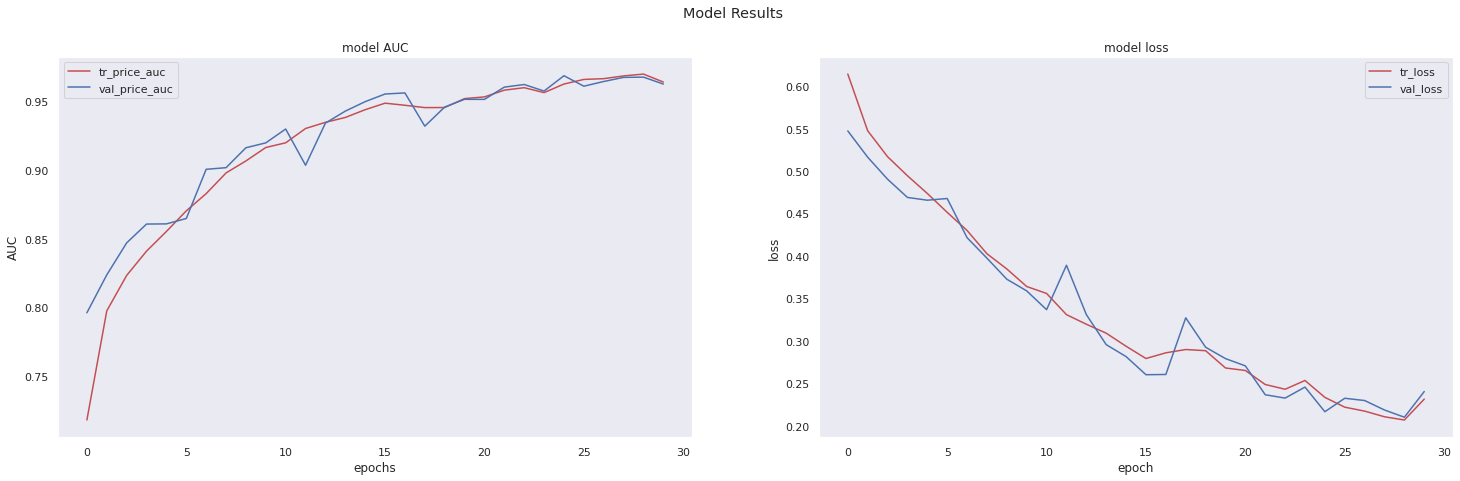

In [ ]:
#virtualize the results
results_virt(hist_7)

In [ ]:
#make a prediction by using the model
y_pred_7 = model_7.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred_7 = np.reshape(y_pred_7, -1)

In [ ]:
#make a submission file to upload it on kaggle
submission = pd.DataFrame({'label':y_pred_7})
submission.index.name = 'id'
submission.to_csv('trial_2_7_GNN_FiLM.csv')

#kaggle ==> 0.86429

> **As we see this model given me**
* around 96.5% training AUC so close to my expectation
* around 96.3% validation AUC score better than what i expected so it's good and this is the second best one until now
* 86.5% score on kaggle which is good
* so this trial was the second best trial

    **[The second highest scores I get, so this model is the second best one so far]**
> **my observation for this results**
* this model was good to reach this result as we see from the plots
* this model is very good has high scores and has low losses so ***this model is the second best model***
* this model hadn't overfitting or underfitting

#--------------------------------------------------------------------------------------------------------------------------------------------



#Problem Formulation

##Define the problem

>  
 * This is a binary classification Task.
 * It is a binary classification problem based on the graph data.
 * The goal is to use the molecular structure of a chemical substance to predict its anticancer activity. The chemical substance can be either positive or negative in terms of lung cancer cell resistance, and so is labelled as 0 or 1.


##What is the input?

> The data is presented in the form of a graph that depicts the compound's chemical structure. Each data sample includes information on the atoms in the molecule as well as the connections between them. The atoms and connections are the inputs features of this problem.


##What is the output?

> the output is the prediction of the anticancer activity of a chemical compound using the chemical structure of the compound. The chemical compound can be positive or negative [0, 1]

##What data mining function is required?

> Import libraries
* which used in the models and to help me to deal with many things like preprocessing and build the models and so on.

> Load the data
* to deal with the model to make a prediction

> Virtualize the data 
* to help me to find any information or pattern

>Data preprocessing
* Characters such as ['O','N','S',....] are used to represent nodes (atoms). As a result, it's viewed as a sequence of text data, with the best method to characterise it being to tokenize the data before adding the embeddig layer.
* Balance the data

>In this assignment, the probability of the output class is calculated using a graph convolutional network. Message passing methods are implemented differently in different approaches, such as:
* GGNN Method
* RGCN Method
* RGAT Method
* RGIN Method
* GNN-Edge-ML Method
* GNN-FILM Method


##What could be the challenges?

>* how to deal with sdf file format
* how to make resampling
* how to find the best model architecture
* how to find the best hyperparameters
* how to avoid overfitting or undefitting
* how to improve the perormance of the models
* there are some models take a long time to run 

##What is the impact?

> The impact of this solution could assist to predict the anticancer activity of a chemical compound using the chemical structure of the compound.

##What is an ideal solution?

> The ideal solution I did is
* ***Trial_2_2*** which give me this results

> 
* around 98% training AUC score
* around 97.6% validation AUC
* 87.3% score on kaggle

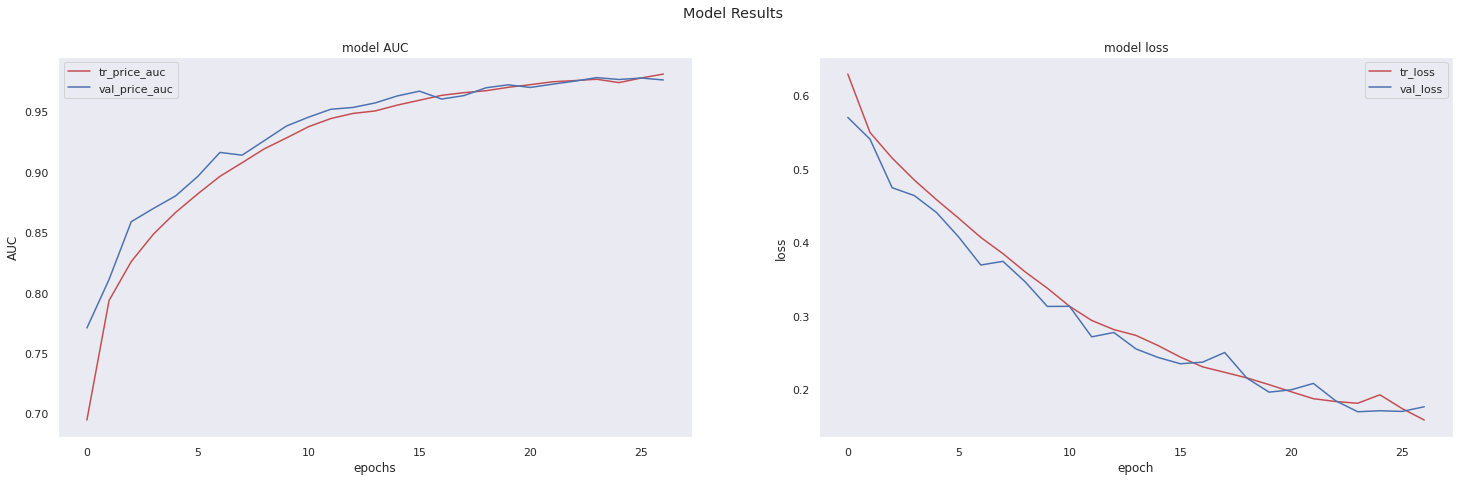

In [ ]:
#virtualize the results
results_virt(hist_2)

#--------------------------------------------------------------------------------------------------------------------------------------------



#Question

##1) Based on the provided template, describe the format of the input file (sdf file).

> The input file is a data structure file (SDF). It contains information on a molecule's chemical composition. SDF files include information about the positions of individual atoms in a chemical molecule as well as the connections between them. The expression \$$$$ distinguishes between different compounds.

>Each sample/molecule begins with a header that describes the compound's name/title. Other sections include details on the amount of Atoms, the version number, and connections, among other things. The constituents of the compound are described in the atom block. The bond block block describes the compound's bonding structure. Both of these blocks are utilised in this assignment to obtain information about the compound and save it as edges and nodes. Each node represents an atom in a chemical compound.

##2) What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?

>The input tensors in this network are:
* **data:** In tokenized form, the data contains the nodes of the chemical molecule. Each compound's nodes are retrieved, then tokenized with the tokenizer, and then padded with the pad sequence method. (batch_size * max_len_nodes) is the form of each batch.where batch_size is the number of samples in the batch and max_len_nodes represents the length of tokenized nodes after padding.$$$$
* **edge:** edge is the input tensor that contains information about atom connections (sum_of_all_edges,2) is the form of an edge.The batch size is represented by the sum(no. of edges of each sample) of the sum of all edges. For example, in a batch of three samples, sample 1 has 21, sample 2 has 20, and sample 3 has 40 edges. As a result, the size of the edge tensor is (81,2).$$$$
* **node2graph:** It is the segmented mean input tensor, which contains information about segmented ids. Each batch has the shape (batch size*max len nodes), with batch size equaling the number of samples in the batch and max_len_nodes equaling the length of tokenized nodes after padding.

##3) For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?

> **dim of gnn_out:** (batch_size_node_dimension,hidden layers) is the shape of the gnn_out, where batch_size_node_dimension is the dimension of the input data (node) vector (dimension of tokenized vector for the complete batch). For each hidden layer, it represents the model's aggregation output.

> **dim of avg:** The segmented mean of the gnn_out is calculated using the segmented ids. The output of gnn_out is (tokenized_vector_dimension, hidden_layers) for each sample in the batch_size. A segment id is assigned to each sample. As a result, segment_mean represents one sample with one number for each hidden_layer by taking the mean of all the output data in the gnn_out output. The avg tensor's final output is of the shape (batch_size, hidden_layer). It's a method of gathering information for each sample and presenting it as mean data.

##4) What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?

> **segment_mean:** calculates the average of data with the same segmented ids.

> **reduce_mean:** Given parameters, computes the mean of elements across dimensions of a tensor.

> **dim of pred:** The final output (pred) indicates whether or not a chemical compound is active against cancer cells. (batch_size,1) is the shape of pred. As a result, the final output for each sample is a number that represents the likelihood associated with each chemical compound's activity.

##5) What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?

> The default template uses the gcn_network's default option for the number of layers. As stated in the documentation, the default layer is **[4]**. rgcn (Graph convolution layers) is the default message passing technique . Using several gcn assists in effectively capturing all graph complexity, resulting in a better model.

#References.

[Ref.](https://wellsr.com/python/upsampling-and-downsampling-imbalanced-data-in-python/)
[Ref.](https://www.projectpro.io/recipes/deal-with-imbalance-classes-with-upsampling-in-python)
[Ref.](https://www.analyticsvidhya.com/blog/2021/07/how-to-perform-data-visualization-with-pandas/)
[Ref.](https://stackoverflow.com/questions/52735334/python-pandas-resample-dataset-to-have-balanced-classes)
[Ref.](https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/)
[Ref.]((https://arxiv.org/pdf/1703.06103.pdf)
[Ref.](https://medium.com/analytics-vidhya/paper-series-2-modeling-relational-data-with-graph-convolutional-networks-schlichtkrull-et-al-b009ff48ab87)
[Ref.](https://arxiv.org/pdf/2107.10015.pdf)
[Ref](https://github.com/babylonhealth/rgat)
[Ref](https://medium.com/analytics-vidhya/a-review-of-graph-neural-networks-gnn-560be37b8bca)
[Ref](https://jonathan-hui.medium.com/graph-neural-networks-gnn-gae-stgnn-1ac0b5c99550)
[Ref](https://www.youtube.com/watch?v=8owQBFAHw7E&ab_channel=TensorFlow)
[Ref.](https://github.com/microsoft/tf2-gnn)
[Ref.](https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py)
[Ref.](https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py)
[Ref.](https://www.tensorflow.org/api_docs/python/tf/math/segment_mean)